## Neural network (the check for quantity of SMOTE is also here!!!)
## Only refer to combination of undersampling and oversampling, better plot is at bottom

In [1]:
import copy
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import keras_tuner as kt

warnings.filterwarnings('ignore')

In [2]:
selected_features_list_removing_correlation = [
    'interarrival_std',
    'interarrival_min',
    'interarrival_max',
    'interarrival_skew',
    'interarrival_moment4',
    'interarrival_max_min_R',
    'interarrival_max_value_count_percent',
    'len_udp_moment4',
    'len_udp_max_min_diff',
    'len_udp_max_value_count_percent',
    'inter_time_sequence_std'
]

full_features_list = []
for feature in selected_features_list_removing_correlation:
    for i in range(1,11):
        col_title = f'{feature}_minus_{500*i}ms'
        full_features_list.append(col_title)

In [3]:
# load the entire dataset

df_complete_with_features_final = pd.read_csv('models/df_final_label_feature.csv')

In [4]:
df_complete_with_features_final

,timestamp,lossOrNot,group_id,interarrival_std_minus_500ms,interarrival_std_minus_1000ms,interarrival_std_minus_1500ms,interarrival_std_minus_2000ms,interarrival_std_minus_2500ms,interarrival_std_minus_3000ms,interarrival_std_minus_3500ms,...,inter_time_sequence_std_minus_500ms,inter_time_sequence_std_minus_1000ms,inter_time_sequence_std_minus_1500ms,inter_time_sequence_std_minus_2000ms,inter_time_sequence_std_minus_2500ms,inter_time_sequence_std_minus_3000ms,inter_time_sequence_std_minus_3500ms,inter_time_sequence_std_minus_4000ms,inter_time_sequence_std_minus_4500ms,inter_time_sequence_std_minus_5000ms
0,2020-12-14 13:34:44.500000,0.0,1,0.185914,0.111167,0.149341,0.168203,0.224819,0.287330,0.584144,...,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376,0.182312,0.000000
1,2020-12-14 13:34:45,0.0,1,0.169699,0.185914,0.111167,0.149341,0.168203,0.224819,0.287330,...,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376,0.182312
2,2020-12-14 13:34:45.500000,0.0,1,0.122365,0.169699,0.185914,0.111167,0.149341,0.168203,0.224819,...,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850,0.452376
3,2020-12-14 13:34:46,0.0,1,0.081800,0.122365,0.169699,0.185914,0.111167,0.149341,0.168203,...,0.438010,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871,0.164850
4,2020-12-14 13:34:46.500000,0.0,1,0.113890,0.081800,0.122365,0.169699,0.185914,0.111167,0.149341,...,0.210085,0.438010,0.336296,0.204396,0.362588,0.420006,0.202741,0.374366,0.419943,0.231871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028655,2020-05-13 14:59:09.000,0.0,6998,0.083744,0.075046,0.078230,0.131936,0.078184,0.058745,0.069150,...,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018,0.213018,0.934599
2028656,2020-05-13 14:59:09.500,0.0,6998,0.083497,0.083744,0.075046,0.078230,0.131936,0.078184,0.058745,...,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018,0.213018
2028657,2020-05-13 14:59:10.000,0.0,6998,0.048801,0.083497,0.083744,0.075046,0.078230,0.131936,0.078184,...,0.822931,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054,0.213018
2028658,2020-05-13 14:59:10.500,0.0,6998,0.133611,0.048801,0.083497,0.083744,0.075046,0.078230,0.131936,...,0.223662,0.822931,0.213018,0.213018,1.000000,0.223662,0.202375,0.839116,0.213018,0.426054


In [5]:
# seperate loss and no loss

df_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] > 0]
df_no_loss = df_complete_with_features_final[df_complete_with_features_final['lossOrNot'] < 1]

df_loss_shuffled = df_loss.sample(frac=1).reset_index()
df_loss_shuffled.drop(['index'], axis=1, inplace=True)
df_no_loss_shuffled = df_no_loss.sample(frac=1).reset_index()
df_no_loss_shuffled.drop(['index'], axis=1, inplace=True)

In [6]:
# oversampling the loss dataset to 10 times and undersampling the no loss dataset to the same quantity

df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7)], df_no_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7 * 10)]])
df_train_shuffled = df_train.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)
df_test = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7)+1: -1], df_no_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7 * 10)+1: -1]])
df_test_shuffled = df_test.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

In [8]:
x_train = df_train_shuffled[full_features_list]
x_test = df_test_shuffled[full_features_list]
y_train = df_train_shuffled[['lossOrNot']]
y_train = y_train.astype(int)
y_test = df_test_shuffled[['lossOrNot']]
y_test = y_test.astype(int)

In [9]:
# oversampling with SMOTE

smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [10]:
x_train_smote.shape

(394896, 110)

In [15]:
# first try

my_model = keras.Sequential([
    keras.layers.Input(shape=(110,)), 
    keras.layers.Dense(80, activation='relu'),
    keras.layers.Dense(40, activation='relu'),
    keras.layers.Dense(2, activation='softmax') 
])

my_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [16]:
my_model.fit(x_train_smote, y_train_smote, epochs=10)

Epoch 1/10
12341/12341 [==============================] - 62s 5ms/step - loss: 0.5741 - accuracy: 0.6931
Epoch 2/10
12341/12341 [==============================] - 61s 5ms/step - loss: 0.5436 - accuracy: 0.7219
Epoch 3/10
12341/12341 [==============================] - 57s 5ms/step - loss: 0.5341 - accuracy: 0.7284
Epoch 4/10
12341/12341 [==============================] - 54s 4ms/step - loss: 0.5302 - accuracy: 0.7309
Epoch 5/10
12341/12341 [==============================] - 62s 5ms/step - loss: 0.5277 - accuracy: 0.7315
Epoch 6/10
12341/12341 [==============================] - 59s 5ms/step - loss: 0.5260 - accuracy: 0.7343
Epoch 7/10
12341/12341 [==============================] - 59s 5ms/step - loss: 0.5232 - accuracy: 0.7354
Epoch 8/10
12341/12341 [==============================] - 63s 5ms/step - loss: 0.5218 - accuracy: 0.7378
Epoch 9/10
12341/12341 [==============================] - 64s 5ms/step - loss: 0.5201 - accuracy: 0.7388
Epoch 10/10
12341/12341 [==============================

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.74      0.85   1803003
           1       0.01      0.70      0.02      8461

    accuracy                           0.74   1811464
   macro avg       0.51      0.72      0.44   1811464
weighted avg       0.99      0.74      0.84   1811464



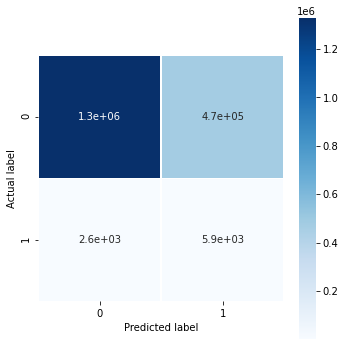

In [17]:
predictions = my_model.predict(x_test)
prediction_label = [np.argmax(x) for x in predictions]
print("Prediction Report\n", classification_report(y_test, prediction_label))
cm = confusion_matrix(y_test['lossOrNot'].tolist(), prediction_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## feature selection

Epoch 1/10
12341/12341 [==============================] - 138s 11ms/step - loss: 0.6544 - accuracy: 0.6111
Epoch 2/10
12341/12341 [==============================] - 116s 9ms/step - loss: 0.6468 - accuracy: 0.6281
Epoch 3/10
12341/12341 [==============================] - 100s 8ms/step - loss: 0.6419 - accuracy: 0.6357
Epoch 4/10
12341/12341 [==============================] - 90s 7ms/step - loss: 0.6387 - accuracy: 0.6399
Epoch 5/10
12341/12341 [==============================] - 118s 10ms/step - loss: 0.6370 - accuracy: 0.6441
Epoch 6/10
12341/12341 [==============================] - 115s 9ms/step - loss: 0.6363 - accuracy: 0.6449
Epoch 7/10
12341/12341 [==============================] - 117s 10ms/step - loss: 0.6361 - accuracy: 0.6452
Epoch 8/10
12341/12341 [==============================] - 110s 9ms/step - loss: 0.6358 - accuracy: 0.6473
Epoch 9/10
12341/12341 [==============================] - 97s 8ms/step - loss: 0.6356 - accuracy: 0.6462
Epoch 10/10
12341/12341 [====================

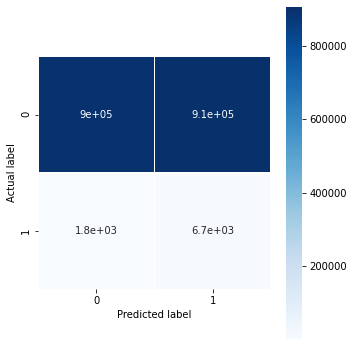

Epoch 1/10
12341/12341 [==============================] - 97s 8ms/step - loss: 0.6071 - accuracy: 0.6690
Epoch 2/10
12341/12341 [==============================] - 99s 8ms/step - loss: 0.5916 - accuracy: 0.6872
Epoch 3/10
12341/12341 [==============================] - 91s 7ms/step - loss: 0.5878 - accuracy: 0.6909
Epoch 4/10
12341/12341 [==============================] - 87s 7ms/step - loss: 0.5859 - accuracy: 0.6923
Epoch 5/10
12341/12341 [==============================] - 90s 7ms/step - loss: 0.5841 - accuracy: 0.6933
Epoch 6/10
12341/12341 [==============================] - 89s 7ms/step - loss: 0.5825 - accuracy: 0.6954
Epoch 7/10
12341/12341 [==============================] - 98s 8ms/step - loss: 0.5811 - accuracy: 0.6957
Epoch 8/10
12341/12341 [==============================] - 105s 8ms/step - loss: 0.5781 - accuracy: 0.6975
Epoch 9/10
12341/12341 [==============================] - 87s 7ms/step - loss: 0.5772 - accuracy: 0.6982
Epoch 10/10
12341/12341 [=============================

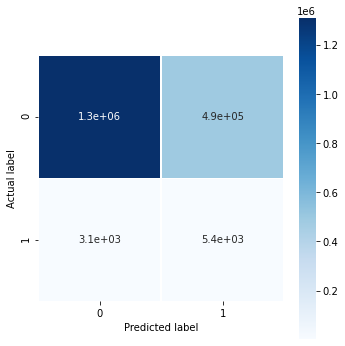

Epoch 1/10
12341/12341 [==============================] - 98s 8ms/step - loss: 0.5817 - accuracy: 0.6860
Epoch 2/10
12341/12341 [==============================] - 89s 7ms/step - loss: 0.5468 - accuracy: 0.7163
Epoch 3/10
12341/12341 [==============================] - 97s 8ms/step - loss: 0.5354 - accuracy: 0.7255
Epoch 4/10
12341/12341 [==============================] - 100s 8ms/step - loss: 0.5282 - accuracy: 0.7323
Epoch 5/10
12341/12341 [==============================] - 90s 7ms/step - loss: 0.5248 - accuracy: 0.7353
Epoch 6/10
12341/12341 [==============================] - 92s 7ms/step - loss: 0.5231 - accuracy: 0.7370
Epoch 7/10
12341/12341 [==============================] - 94s 8ms/step - loss: 0.5211 - accuracy: 0.7370
Epoch 8/10
12341/12341 [==============================] - 95s 8ms/step - loss: 0.5202 - accuracy: 0.7372
Epoch 9/10
12341/12341 [==============================] - 96s 8ms/step - loss: 0.5189 - accuracy: 0.7388
Epoch 10/10
12341/12341 [=============================

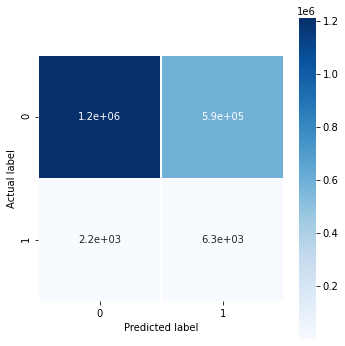

Epoch 1/10
12341/12341 [==============================] - 90s 7ms/step - loss: 0.5866 - accuracy: 0.6828
Epoch 2/10
12341/12341 [==============================] - 92s 7ms/step - loss: 0.5638 - accuracy: 0.7055
Epoch 3/10
12341/12341 [==============================] - 94s 8ms/step - loss: 0.5570 - accuracy: 0.7112
Epoch 4/10
12341/12341 [==============================] - 92s 7ms/step - loss: 0.5522 - accuracy: 0.7153
Epoch 5/10
12341/12341 [==============================] - 80s 6ms/step - loss: 0.5486 - accuracy: 0.7166
Epoch 6/10
12341/12341 [==============================] - 89s 7ms/step - loss: 0.5460 - accuracy: 0.7187
Epoch 7/10
12341/12341 [==============================] - 83s 7ms/step - loss: 0.5444 - accuracy: 0.7205
Epoch 8/10
12341/12341 [==============================] - 63s 5ms/step - loss: 0.5430 - accuracy: 0.7213
Epoch 9/10
12341/12341 [==============================] - 52s 4ms/step - loss: 0.5403 - accuracy: 0.7237
Epoch 10/10
12341/12341 [==============================

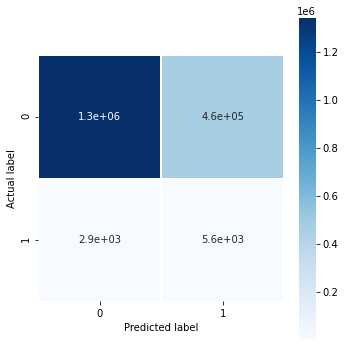

Epoch 1/10
12341/12341 [==============================] - 51s 4ms/step - loss: 0.5768 - accuracy: 0.6936
Epoch 2/10
12341/12341 [==============================] - 54s 4ms/step - loss: 0.5397 - accuracy: 0.7257
Epoch 3/10
12341/12341 [==============================] - 77s 6ms/step - loss: 0.5306 - accuracy: 0.7329
Epoch 4/10
12341/12341 [==============================] - 94s 8ms/step - loss: 0.5259 - accuracy: 0.7350
Epoch 5/10
12341/12341 [==============================] - 87s 7ms/step - loss: 0.5232 - accuracy: 0.7369
Epoch 6/10
12341/12341 [==============================] - 74s 6ms/step - loss: 0.5212 - accuracy: 0.7374
Epoch 7/10
12341/12341 [==============================] - 70s 6ms/step - loss: 0.5195 - accuracy: 0.7391
Epoch 8/10
12341/12341 [==============================] - 69s 6ms/step - loss: 0.5182 - accuracy: 0.7396
Epoch 9/10
12341/12341 [==============================] - 69s 6ms/step - loss: 0.5165 - accuracy: 0.7404
Epoch 10/10
12341/12341 [==============================

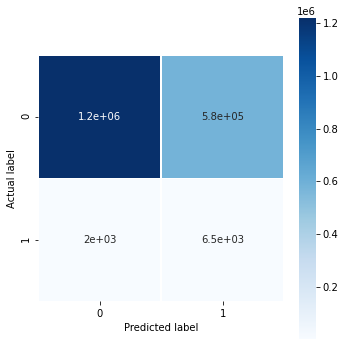

Epoch 1/10
12341/12341 [==============================] - 82s 7ms/step - loss: 0.5708 - accuracy: 0.6966
Epoch 2/10
12341/12341 [==============================] - 83s 7ms/step - loss: 0.5390 - accuracy: 0.7270
Epoch 3/10
12341/12341 [==============================] - 74s 6ms/step - loss: 0.5314 - accuracy: 0.7324
Epoch 4/10
12341/12341 [==============================] - 75s 6ms/step - loss: 0.5271 - accuracy: 0.7358
Epoch 5/10
12341/12341 [==============================] - 72s 6ms/step - loss: 0.5253 - accuracy: 0.7363
Epoch 6/10
12341/12341 [==============================] - 89s 7ms/step - loss: 0.5233 - accuracy: 0.7369
Epoch 7/10
12341/12341 [==============================] - 98s 8ms/step - loss: 0.5218 - accuracy: 0.7372
Epoch 8/10
12341/12341 [==============================] - 111s 9ms/step - loss: 0.5211 - accuracy: 0.7386
Epoch 9/10
12341/12341 [==============================] - 91s 7ms/step - loss: 0.5196 - accuracy: 0.7399
Epoch 10/10
12341/12341 [=============================

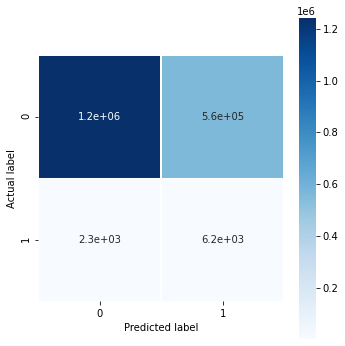

Epoch 1/10
12341/12341 [==============================] - 77s 6ms/step - loss: 0.5706 - accuracy: 0.6943
Epoch 2/10
12341/12341 [==============================] - 78s 6ms/step - loss: 0.5346 - accuracy: 0.7239
Epoch 3/10
12341/12341 [==============================] - 91s 7ms/step - loss: 0.5229 - accuracy: 0.7334
Epoch 4/10
12341/12341 [==============================] - 81s 7ms/step - loss: 0.5176 - accuracy: 0.7370
Epoch 5/10
12341/12341 [==============================] - 104s 8ms/step - loss: 0.5144 - accuracy: 0.7396
Epoch 6/10
12341/12341 [==============================] - 99s 8ms/step - loss: 0.5112 - accuracy: 0.7422
Epoch 7/10
12341/12341 [==============================] - 84s 7ms/step - loss: 0.5094 - accuracy: 0.7429
Epoch 8/10
12341/12341 [==============================] - 46s 4ms/step - loss: 0.5069 - accuracy: 0.7444
Epoch 9/10
12341/12341 [==============================] - 50s 4ms/step - loss: 0.5062 - accuracy: 0.7459
Epoch 10/10
12341/12341 [=============================

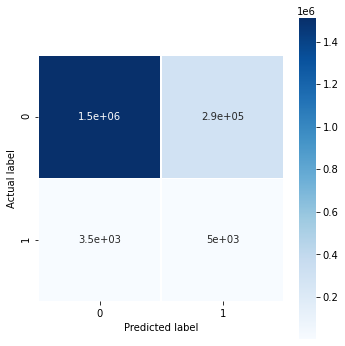

Epoch 1/10
12341/12341 [==============================] - 45s 4ms/step - loss: 0.5660 - accuracy: 0.7053
Epoch 2/10
12341/12341 [==============================] - 46s 4ms/step - loss: 0.5356 - accuracy: 0.7302
Epoch 3/10
12341/12341 [==============================] - 46s 4ms/step - loss: 0.5239 - accuracy: 0.7382
Epoch 4/10
12341/12341 [==============================] - 47s 4ms/step - loss: 0.5152 - accuracy: 0.7436
Epoch 5/10
12341/12341 [==============================] - 64s 5ms/step - loss: 0.5102 - accuracy: 0.7466
Epoch 6/10
12341/12341 [==============================] - 100s 8ms/step - loss: 0.5066 - accuracy: 0.7488
Epoch 7/10
12341/12341 [==============================] - 88s 7ms/step - loss: 0.5046 - accuracy: 0.7506
Epoch 8/10
12341/12341 [==============================] - 89s 7ms/step - loss: 0.5023 - accuracy: 0.7529
Epoch 9/10
12341/12341 [==============================] - 82s 7ms/step - loss: 0.5013 - accuracy: 0.7530
Epoch 10/10
12341/12341 [=============================

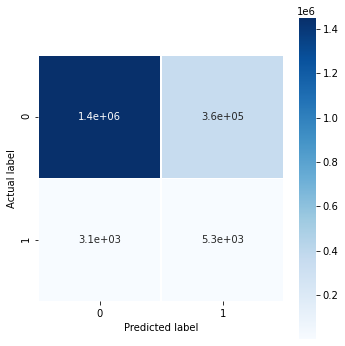

Epoch 1/10
12341/12341 [==============================] - 94s 8ms/step - loss: 0.5704 - accuracy: 0.6917
Epoch 2/10
12341/12341 [==============================] - 86s 7ms/step - loss: 0.5377 - accuracy: 0.7194
Epoch 3/10
12341/12341 [==============================] - 78s 6ms/step - loss: 0.5299 - accuracy: 0.7266
Epoch 4/10
12341/12341 [==============================] - 92s 7ms/step - loss: 0.5232 - accuracy: 0.7324
Epoch 5/10
12341/12341 [==============================] - 95s 8ms/step - loss: 0.5206 - accuracy: 0.7375
Epoch 6/10
12341/12341 [==============================] - 94s 8ms/step - loss: 0.5184 - accuracy: 0.7397
Epoch 7/10
12341/12341 [==============================] - 93s 8ms/step - loss: 0.5166 - accuracy: 0.7415
Epoch 8/10
12341/12341 [==============================] - 83s 7ms/step - loss: 0.5146 - accuracy: 0.7416
Epoch 9/10
12341/12341 [==============================] - 85s 7ms/step - loss: 0.5111 - accuracy: 0.7429
Epoch 10/10
12341/12341 [==============================

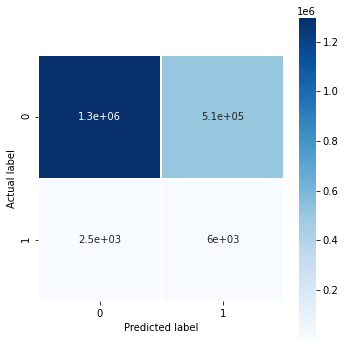

Epoch 1/10
12341/12341 [==============================] - 72s 6ms/step - loss: 0.5520 - accuracy: 0.7148
Epoch 2/10
12341/12341 [==============================] - 84s 7ms/step - loss: 0.5070 - accuracy: 0.7471
Epoch 3/10
12341/12341 [==============================] - 86s 7ms/step - loss: 0.4973 - accuracy: 0.7531
Epoch 4/10
12341/12341 [==============================] - 78s 6ms/step - loss: 0.4908 - accuracy: 0.7555
Epoch 5/10
12341/12341 [==============================] - 84s 7ms/step - loss: 0.4876 - accuracy: 0.7577
Epoch 6/10
12341/12341 [==============================] - 89s 7ms/step - loss: 0.4855 - accuracy: 0.7582
Epoch 7/10
12341/12341 [==============================] - 91s 7ms/step - loss: 0.4822 - accuracy: 0.7613
Epoch 8/10
12341/12341 [==============================] - 94s 8ms/step - loss: 0.4803 - accuracy: 0.7622
Epoch 9/10
12341/12341 [==============================] - 87s 7ms/step - loss: 0.4791 - accuracy: 0.7615
Epoch 10/10
12341/12341 [==============================

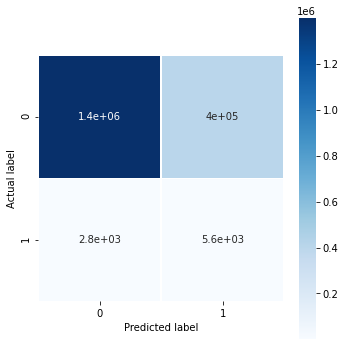

In [32]:
# select value starting from past 5 sec (10 samples) to 0.5 sec (1 sample)

for num_feature in range(2,12):
    
    # build features
    shrink_feature_list = []
    for feature in selected_features_list_removing_correlation:
        for i in range(1, num_feature):
            col_title = f'{feature}_minus_{500*i}ms'
            shrink_feature_list.append(col_title)
            
    # build training and testing dataset
    x_train_new = df_train_shuffled[shrink_feature_list]
    x_test_new = df_test_shuffled[shrink_feature_list]
    y_train_new = df_train_shuffled[['lossOrNot']]
    y_train_new = y_train_new.astype(int)
    y_test_new = df_test_shuffled[['lossOrNot']]
    y_test_new = y_test_new.astype(int)
    
    input_size = x_train_new.shape[1]
    
    # oversampling with SMOTE
    smote = SMOTE()
    x_train_smote_new, y_train_smote_new = smote.fit_resample(x_train_new, y_train_new)
    
    # build nn model
    my_model_new = keras.Sequential([
        keras.layers.Input(shape=(input_size,)), 
        keras.layers.Dense(int(input_size/3*2), activation='relu'),
        keras.layers.Dense(int(input_size/3), activation='relu'),
        keras.layers.Dense(2, activation='softmax') 
    ])

    my_model_new.compile(
        optimizer=tf.keras.optimizers.Adam(0.01),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    # fit model
    my_model_new.fit(x_train_smote_new, y_train_smote_new, epochs=10)
    
    # output result
    predictions = my_model_new.predict(x_test_new)
    prediction_label = [np.argmax(x) for x in predictions]
    print(f"Prediction Report with features of past {(num_feature-1)*500}ms\n", classification_report(y_test_new, prediction_label))
    cm = confusion_matrix(y_test_new['lossOrNot'].tolist(), prediction_label)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

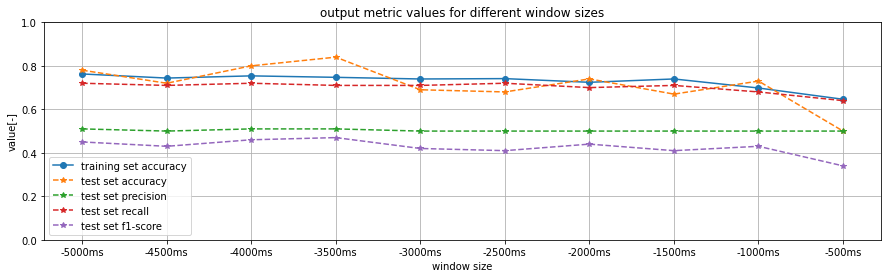

In [117]:
# the best window size is -3500ms!!!

training_acc = [0.7627, 0.7438, 0.7539, 0.7472, 0.7396, 0.7413, 0.7243, 0.7397, 0.6981, 0.6463]
test_acc = [0.78, 0.72, 0.80, 0.84, 0.69, 0.68, 0.74, 0.67, 0.73, 0.50]
precision = [0.51, 0.50, 0.51, 0.51, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50]                                                        
recall = [0.72, 0.71, 0.72, 0.71, 0.71, 0.72, 0.70, 0.71, 0.68, 0.64]
f1 = [0.45, 0.43, 0.46, 0.47, 0.42, 0.41, 0.44, 0.41, 0.43, 0.34]
label = [f'-{500*x}ms' for x in range(10, 0, -1)]

plt.figure(figsize=(15,4))
plt.ylim(0,1)
plt.plot(label, training_acc, 'o-', label='training set accuracy')
plt.plot(label, test_acc, '*--', label='test set accuracy')
plt.plot(label, precision, '*--', label='test set precision')
plt.plot(label, recall, '*--', label='test set recall')
plt.plot(label, f1, '*--', label='test set f1-score')
plt.legend()
plt.xlabel('window size')
plt.ylabel('value[-]')
plt.title('output metric values for different window sizes')
plt.grid()
plt.show()

## model tuning

In [6]:
# define validation dataset
# oversampling to 12 times since 10% of original dataset are used as validation

#training
df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.6)], df_no_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.6 * 12)]])
df_train_shuffled = df_train.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)

# validation
df_validation = pd.concat([
    df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0]*0.6)+1 : int(df_loss_shuffled.shape[0]*0.7)], 
    df_no_loss_shuffled.iloc[int(df_loss_shuffled.shape[0]*0.6*12)+1 : int(df_loss_shuffled.shape[0]*(0.6*12+0.1))]
])
df_validation_shuffled = df_validation.sample(frac=1).reset_index()
df_validation_shuffled.drop(['index'], axis=1, inplace=True)

# test
df_test = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0]*0.7)+1: -1], df_no_loss_shuffled.iloc[int(df_loss_shuffled.shape[0]*(0.6*12+0.1))+1: -1]])
df_test_shuffled = df_test.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

# build features for past 3500ms (7 samples)
shrink_feature_list = []
for feature in selected_features_list_removing_correlation:
    for i in range(1, 8):
        col_title = f'{feature}_minus_{500*i}ms'
        shrink_feature_list.append(col_title)

x_train = df_train_shuffled[shrink_feature_list]
x_validation = df_validation_shuffled[shrink_feature_list]
x_test = df_test_shuffled[shrink_feature_list]
y_train = df_train_shuffled[['lossOrNot']]
y_train = y_train.astype(int)
y_validation = df_validation_shuffled[['lossOrNot']]
y_validation = y_validation.astype(int)
y_test = df_test_shuffled[['lossOrNot']]
y_test = y_test.astype(int)

smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [7]:
x_train_smote.shape

(406180, 77)

In [102]:
# model tuning

def build_model(hp):
    
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(77,)))
    for i in range(hp.Int("num_layers", 1, 4)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f"units_{i}", min_value=20, max_value=80, step=20),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
        if hp.Boolean("dropout"):
            model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(2, activation="softmax"))
    
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    
    return model

build_model(kt.HyperParameters())

In [106]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=100,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name="tuning_nn_predeiction_loss",
)

In [107]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 80, 'step': 20, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [108]:
tuner.search(x_train_smote, y_train_smote, epochs=2, validation_data=(x_validation, y_validation))

Trial 100 Complete [00h 01m 47s]
val_accuracy: 0.6916120052337646

Best val_accuracy So Far: 0.7441035509109497
Total elapsed time: 03h 36m 54s
INFO:tensorflow:Oracle triggered exit


In [109]:
tuner.results_summary()

Results summary
Results in my_dir/tuning_nn_predeiction_loss
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 3
units_0: 60
activation: tanh
dropout: False
lr: 0.0007413347931556125
units_1: 60
units_2: 60
units_3: 20
Score: 0.7441035509109497
Trial summary
Hyperparameters:
num_layers: 3
units_0: 60
activation: tanh
dropout: False
lr: 0.00206871879825104
units_1: 40
units_2: 60
units_3: 60
Score: 0.7412661910057068
Trial summary
Hyperparameters:
num_layers: 4
units_0: 40
activation: relu
dropout: False
lr: 0.0014195108563380763
units_1: 60
units_2: 60
units_3: 40
Score: 0.7409114837646484
Trial summary
Hyperparameters:
num_layers: 3
units_0: 60
activation: relu
dropout: False
lr: 0.0022982529652963313
units_1: 60
units_2: 40
units_3: 20
Score: 0.7409114837646484
Trial summary
Hyperparameters:
num_layers: 4
units_0: 80
activation: tanh
dropout: False
lr: 0.0006630040264094734
units_1: 60
units_2: 40
units_3: 40
Score: 0.7375420928001404
Trial summary
Hyperparameters:
nu

In [ ]:
# best para:
# Trial summary
# Hyperparameters:
# num_layers: 3
# units_0: 60
# activation: tanh
# dropout: False
# lr: 0.0007413347931556125
# units_1: 60
# units_2: 60
# units_3: 20
# Score: 0.7441035509109497

best_hps = tuner.get_best_hyperparameters(5)
my_final_model = build_model(best_hps[0])

# # put train and validation together
x_train_all = pd.concat([x_train_smote, x_validation])
y_train_all = pd.concat([y_train_smote, y_validation])

In [115]:
my_final_model.fit(x=x_train_all, y=y_train_all, epochs=20)

Epoch 1/20
12870/12870 [==============================] - 66s 5ms/step - loss: 0.4794 - accuracy: 0.7676
Epoch 2/20
12870/12870 [==============================] - 71s 6ms/step - loss: 0.4472 - accuracy: 0.7890
Epoch 3/20
12870/12870 [==============================] - 65s 5ms/step - loss: 0.4253 - accuracy: 0.8025
Epoch 4/20
12870/12870 [==============================] - 58s 4ms/step - loss: 0.4099 - accuracy: 0.8113
Epoch 5/20
12870/12870 [==============================] - 60s 5ms/step - loss: 0.3979 - accuracy: 0.8180
Epoch 6/20
12870/12870 [==============================] - 60s 5ms/step - loss: 0.3871 - accuracy: 0.8241
Epoch 7/20
12870/12870 [==============================] - 61s 5ms/step - loss: 0.3785 - accuracy: 0.8281
Epoch 8/20
12870/12870 [==============================] - 65s 5ms/step - loss: 0.3717 - accuracy: 0.8319
Epoch 9/20
12870/12870 [==============================] - 59s 5ms/step - loss: 0.3650 - accuracy: 0.8359
Epoch 10/20
12870/12870 [==============================

In [114]:
# my_final_model.save('models/my_second_nn_model_combination')
# my_final_model_loaded = keras.models.load_model('models/my_second_nn_model_combination')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/my_second_nn_model_combination/assets


Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.84      0.91   1794540
           1       0.02      0.66      0.04      8461

    accuracy                           0.84   1803001
   macro avg       0.51      0.75      0.48   1803001
weighted avg       0.99      0.84      0.91   1803001



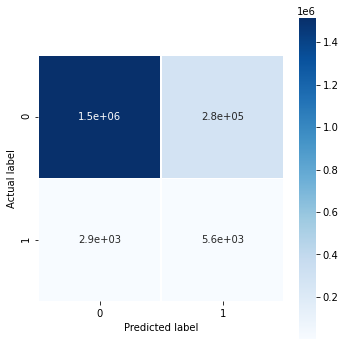

In [116]:
predictions = my_final_model.predict(x_test)
prediction_label = [np.argmax(x) for x in predictions]
print("Prediction Report\n", classification_report(y_test, prediction_label))
cm = confusion_matrix(y_test['lossOrNot'].tolist(), prediction_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [180]:
df_per_group = df_complete_with_features_final[df_complete_with_features_final['group_id'] == 9].copy()
predictions_per_group = my_final_model.predict(df_per_group[shrink_feature_list])
prediction_label_per_group = [np.argmax(x) for x in predictions_per_group]
prediction_prob_per_group = [x[1] for x in predictions_per_group]

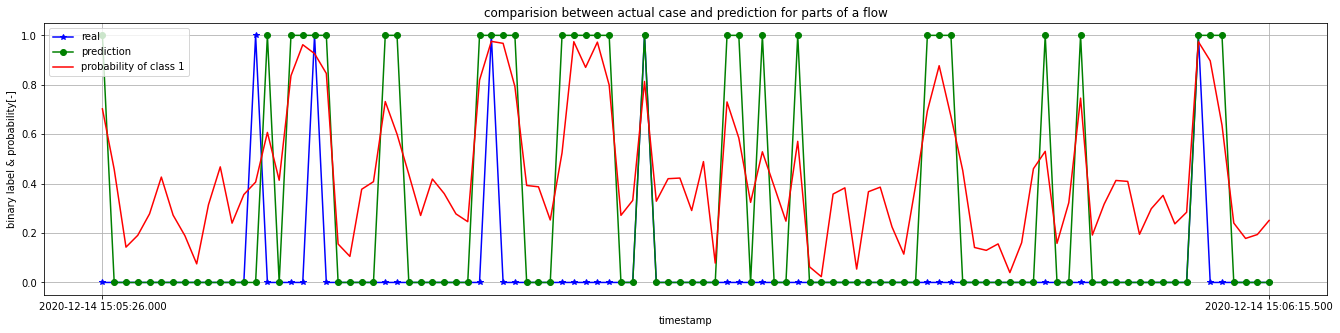

In [197]:
x_time_list = [df_per_group.iloc[0]['timestamp']+'.000', df_per_group.iloc[99]['timestamp'][:-3]]
plt.figure(figsize=(23,5))
plt.plot(df_per_group.iloc[0:100]['lossOrNot'].tolist(), '*-', color='b', label='real')
plt.plot(prediction_label_per_group[0:100], 'o-', color='g', label='prediction')
plt.plot(prediction_prob_per_group[0:100], color='r', label='probability of class 1')
plt.xticks([0, 99], x_time_list)
plt.xlabel('timestamp')
plt.ylabel('binary label & probability[-]')
plt.title('comparision between actual case and prediction for parts of a flow')
plt.legend()
plt.grid()
plt.show()

## try with removing less informative features

In [198]:
selected_features_list_removing_correlation_reduce = [
    'interarrival_std',
    'interarrival_max',
    'interarrival_skew',
    'interarrival_moment4',
    'interarrival_max_min_R',
    'len_udp_moment4',
    'len_udp_max_value_count_percent',
    'inter_time_sequence_std'
]

shrink_features_list_reduce = []
for feature in selected_features_list_removing_correlation_reduce:
    for i in range(1,8):
        col_title = f'{feature}_minus_{500*i}ms'
        shrink_features_list_reduce.append(col_title)

In [199]:
x_train_reduce = x_train_all[shrink_features_list_reduce].copy()
y_train_reduce = copy.deepcopy(y_train_all)
x_test_reduce = x_test[shrink_features_list_reduce].copy()
y_test_reduce = copy.deepcopy(y_test)

In [201]:
x_train_reduce.shape

(411819, 56)

In [202]:
# best para:
# Trial summary
# Hyperparameters:
# num_layers: 3
# units_0: 60
# activation: tanh
# dropout: False
# lr: 0.0007413347931556125
# units_1: 60
# units_2: 60
# units_3: 20
# Score: 0.7441035509109497

my_model_reduce = keras.Sequential([
    keras.layers.Input(shape=(56,)), 
    keras.layers.Dense(60, activation='tanh'),
    keras.layers.Dense(60, activation='tanh'),
    keras.layers.Dense(20, activation='tanh'),
    keras.layers.Dense(2, activation='softmax') 
])

my_model_reduce.compile(
    optimizer=tf.keras.optimizers.Adam(0.00074),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [207]:
my_model_reduce.fit(x_train_reduce, y_train_reduce, epochs=10) # 30 epoch in total

Epoch 1/10
12870/12870 [==============================] - 69s 5ms/step - loss: 0.3821 - accuracy: 0.8257
Epoch 2/10
12870/12870 [==============================] - 66s 5ms/step - loss: 0.3802 - accuracy: 0.8261
Epoch 3/10
12870/12870 [==============================] - 68s 5ms/step - loss: 0.3785 - accuracy: 0.8279
Epoch 4/10
12870/12870 [==============================] - 67s 5ms/step - loss: 0.3764 - accuracy: 0.8287
Epoch 5/10
12870/12870 [==============================] - 63s 5ms/step - loss: 0.3749 - accuracy: 0.8298
Epoch 6/10
12870/12870 [==============================] - 61s 5ms/step - loss: 0.3730 - accuracy: 0.8308
Epoch 7/10
12870/12870 [==============================] - 64s 5ms/step - loss: 0.3717 - accuracy: 0.8322
Epoch 8/10
12870/12870 [==============================] - 62s 5ms/step - loss: 0.3698 - accuracy: 0.8330
Epoch 9/10
12870/12870 [==============================] - 68s 5ms/step - loss: 0.3683 - accuracy: 0.8334
Epoch 10/10
12870/12870 [==============================

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.80      0.89   1794540
           1       0.02      0.67      0.03      8461

    accuracy                           0.80   1803001
   macro avg       0.51      0.74      0.46   1803001
weighted avg       0.99      0.80      0.89   1803001



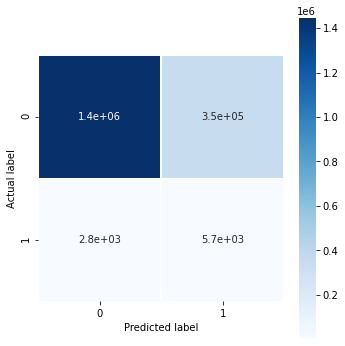

In [208]:
predictions_reduce = my_model_reduce.predict(x_test_reduce)
prediction_label_reduce = [np.argmax(x) for x in predictions_reduce]
print("Prediction Report\n", classification_report(y_test_reduce, prediction_label_reduce))
cm_reduce = confusion_matrix(y_test_reduce['lossOrNot'].tolist(), prediction_label_reduce)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm_reduce, linewidths=.5, annot=True, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## try with undersampling

In [244]:
df_train_pure = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.6)], df_no_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.6)]])
df_train_shuffled = df_train_pure.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)
df_test_dirty = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.6)+1: -1], df_no_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.6)+1: -1]])
df_test_shuffled = df_test_dirty.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

In [245]:
x_train = df_train_shuffled[shrink_feature_list]
x_test = df_test_shuffled[shrink_feature_list]
y_train = df_train_shuffled[['lossOrNot']]
y_train = y_train.astype(int)
y_test = df_test_shuffled[['lossOrNot']]
y_test = y_test.astype(int)

In [250]:
my_model_pure = keras.Sequential([
    keras.layers.Input(shape=(77,)), 
    keras.layers.Dense(60, activation='tanh'),
    keras.layers.Dense(60, activation='tanh'),
    keras.layers.Dense(20, activation='tanh'),
    keras.layers.Dense(2, activation='softmax') 
])

my_model_pure.compile(
    optimizer=tf.keras.optimizers.Adam(0.00074),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [256]:
my_model_pure.fit(x_train, y_train, epochs=10)

Epoch 1/10
1058/1058 [==============================] - 5s 5ms/step - loss: 0.3980 - accuracy: 0.8168
Epoch 2/10
1058/1058 [==============================] - 4s 4ms/step - loss: 0.3967 - accuracy: 0.8179
Epoch 3/10
1058/1058 [==============================] - 4s 3ms/step - loss: 0.3944 - accuracy: 0.8190
Epoch 4/10
1058/1058 [==============================] - 4s 4ms/step - loss: 0.3922 - accuracy: 0.8199
Epoch 5/10
1058/1058 [==============================] - 4s 4ms/step - loss: 0.3893 - accuracy: 0.8231
Epoch 6/10
1058/1058 [==============================] - 4s 4ms/step - loss: 0.3887 - accuracy: 0.8227
Epoch 7/10
1058/1058 [==============================] - 4s 3ms/step - loss: 0.3863 - accuracy: 0.8221
Epoch 8/10
1058/1058 [==============================] - 4s 3ms/step - loss: 0.3853 - accuracy: 0.8257
Epoch 9/10
1058/1058 [==============================] - 4s 4ms/step - loss: 0.3830 - accuracy: 0.8256
Epoch 10/10
1058/1058 [==============================] - 4s 3ms/step - loss: 0.380

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.75      0.86   1983527
           1       0.02      0.75      0.03     11281

    accuracy                           0.75   1994808
   macro avg       0.51      0.75      0.45   1994808
weighted avg       0.99      0.75      0.85   1994808



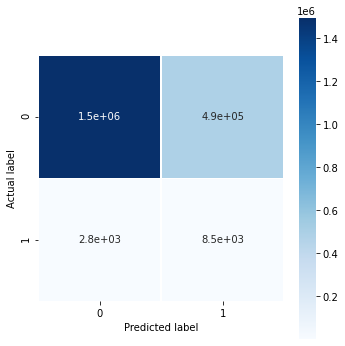

In [257]:
predictions_pure = my_model_pure.predict(x_test)
prediction_label_pure = [np.argmax(x) for x in predictions_pure]
print("Prediction Report\n", classification_report(y_test, prediction_label_pure))
cm_pure = confusion_matrix(y_test['lossOrNot'].tolist(), prediction_label_pure)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm_pure, linewidths=.5, annot=True, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## second way: a grid search (not needed)

In [78]:
# # another way to tuning

# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV

In [94]:
# def create_model(layers, activation, dropout):
    
#     model = keras.Sequential()
#     model.add(keras.layers.Input(shape=(77,)))
#     for layer in layers:
#         model.add(keras.layers.Dense(layer, activation=activation))
#         if dropout:
#             model.add(keras.layers.Dropout(0.2))            
#     model.add(keras.layers.Dense(units=2, activation='softmax')) 
    
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=0.007),
#         loss=keras.losses.SparseCategoricalCrossentropy(),
#         metrics=["accuracy"]
#     )
    
#     return model
    
# my_model_tuning = KerasClassifier(build_fn=create_model, verbose=0)

In [97]:
# layers = [(20, 20), (40, 20), (45, 10)]
# activations = ['relu', 'tanh']
# dropouts = [True, False]
# param_grid = dict(layers=layers, activation=activations, dropout=dropouts, batch_size = [128, 256], epochs=[30])
# grid = GridSearchCV(estimator=my_model_tuning, param_grid=param_grid)

In [ ]:
# grid_result = grid.fit(x_train_smote, y_train_smote)

## better output

In [39]:
# x_train_all = pd.concat([x_train_smote, x_validation])
# y_train_all = pd.concat([y_train_smote, y_validation])

In [40]:
# my_model = keras.Sequential([
#     keras.layers.Input(shape=(77,)), 
#     keras.layers.Dense(60, activation='tanh'),
#     keras.layers.Dense(60, activation='tanh'),
#     keras.layers.Dense(20, activation='tanh'),
#     keras.layers.Dense(2, activation='softmax') 
# ])

# my_model.compile(
#     optimizer=tf.keras.optimizers.Adam(0.00074),
#     loss=keras.losses.SparseCategoricalCrossentropy(),
#     metrics=['accuracy']
# )

In [45]:
# my_model.fit(x=x_train_all, y=y_train_all, epochs=5)

Epoch 1/5
12870/12870 [==============================] - 61s 5ms/step - loss: 0.3503 - accuracy: 0.8450
Epoch 2/5
12870/12870 [==============================] - 63s 5ms/step - loss: 0.3468 - accuracy: 0.8475
Epoch 3/5
12870/12870 [==============================] - 62s 5ms/step - loss: 0.3443 - accuracy: 0.8487
Epoch 4/5
12870/12870 [==============================] - 63s 5ms/step - loss: 0.3412 - accuracy: 0.8499
Epoch 5/5
12870/12870 [==============================] - 62s 5ms/step - loss: 0.3391 - accuracy: 0.8512


Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.82      0.90   1794540
           1       0.02      0.69      0.04      8461

    accuracy                           0.82   1803001
   macro avg       0.51      0.76      0.47   1803001
weighted avg       0.99      0.82      0.90   1803001



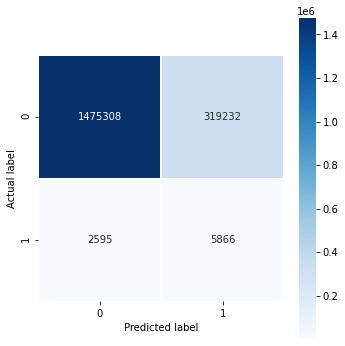

In [44]:
# predictions = my_model.predict(x_test)
# prediction_label = [np.argmax(x) for x in predictions]
# print("Prediction Report\n", classification_report(y_test, prediction_label))
# cm = confusion_matrix(y_test, prediction_label)
# plt.figure(figsize=(5,5))
# sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
# plt.ylabel('Actual label')
# plt.xlabel('Predicted label')
# plt.tight_layout()
# plt.show()

## Check different quantity of SMOTE for decision tree (not include in this chapter but previous one)

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

print(f'70% of no loss dataset for training is {len(df_no_loss_shuffled)*0.7 / (len(df_loss_shuffled)*0.7)} times of 70% loss dataset.')

70% of no loss dataset for training is 70.92044527954054 times of 70% loss dataset.


In [7]:
shrink_feature_list = []
for feature in selected_features_list_removing_correlation:
    for i in range(1, 8):
        col_title = f'{feature}_minus_{500*i}ms'
        shrink_feature_list.append(col_title)

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.68      0.81   1980707
           1       0.01      0.69      0.02      8461

    accuracy                           0.68   1989168
   macro avg       0.50      0.68      0.41   1989168
weighted avg       0.99      0.68      0.81   1989168



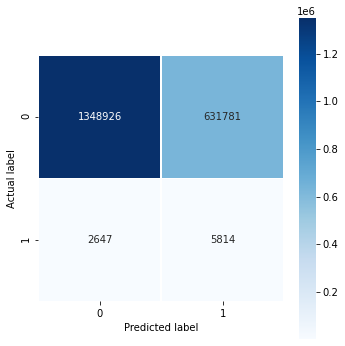

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.84      0.91   1803003
           1       0.01      0.48      0.03      8461

    accuracy                           0.84   1811464
   macro avg       0.51      0.66      0.47   1811464
weighted avg       0.99      0.84      0.91   1811464



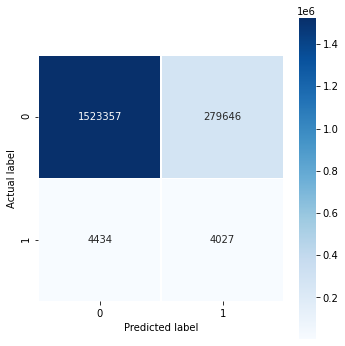

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.88      0.94   1605554
           1       0.02      0.42      0.04      8461

    accuracy                           0.88   1614015
   macro avg       0.51      0.65      0.49   1614015
weighted avg       0.99      0.88      0.93   1614015



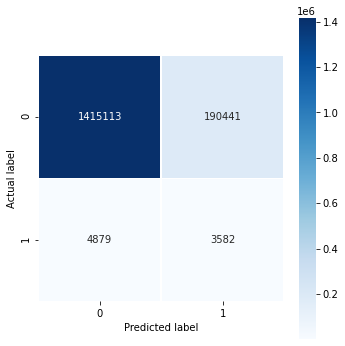

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.90      0.95   1408105
           1       0.02      0.37      0.04      8461

    accuracy                           0.90   1416566
   macro avg       0.51      0.64      0.49   1416566
weighted avg       0.99      0.90      0.94   1416566



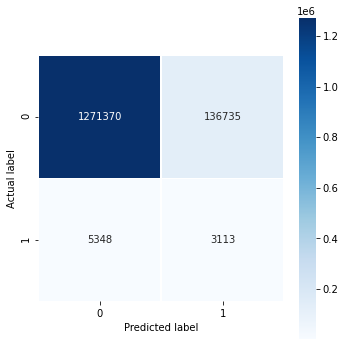

Prediction Report
               precision    recall  f1-score   support

           0       0.99      0.91      0.95   1210656
           1       0.03      0.33      0.05      8461

    accuracy                           0.91   1219117
   macro avg       0.51      0.62      0.50   1219117
weighted avg       0.99      0.91      0.95   1219117



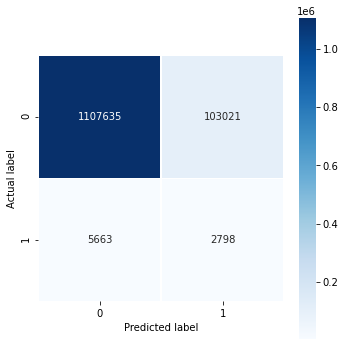

Prediction Report
               precision    recall  f1-score   support

           0       0.99      0.92      0.96   1013207
           1       0.03      0.32      0.06      8461

    accuracy                           0.92   1021668
   macro avg       0.51      0.62      0.51   1021668
weighted avg       0.99      0.92      0.95   1021668



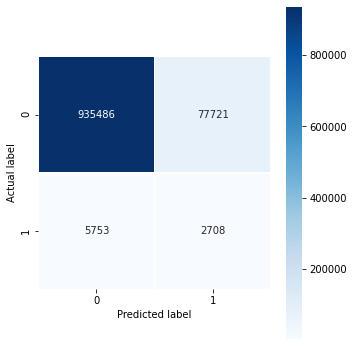

Prediction Report
               precision    recall  f1-score   support

           0       0.99      0.93      0.96    815758
           1       0.04      0.31      0.08      8461

    accuracy                           0.92    824219
   macro avg       0.52      0.62      0.52    824219
weighted avg       0.98      0.92      0.95    824219



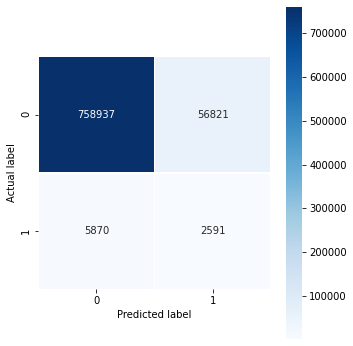

Prediction Report
               precision    recall  f1-score   support

           0       0.99      0.94      0.96    618309
           1       0.06      0.30      0.10      8461

    accuracy                           0.93    626770
   macro avg       0.52      0.62      0.53    626770
weighted avg       0.98      0.93      0.95    626770



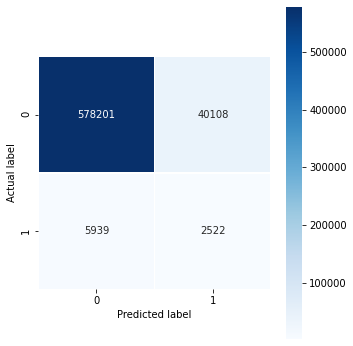

In [41]:
acc = []
precision = []                                         
recall = []
f1 = []
recall_0_list = []
recall_1_list = []
fpr_list = []
tpr_list = []
roc_auc_list = []

num_quantity_time = [1]
num_quantity_time.extend(list(range(10, 71, 10)))

for num in num_quantity_time:
    df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7)], df_no_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.7 * num)]])
    df_train_shuffled = df_train.sample(frac=1).reset_index()
    df_train_shuffled.drop(['index'], axis=1, inplace=True)
    df_test = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7)+1: -1], df_no_loss_shuffled.iloc[int(df_loss_shuffled.shape[0] * 0.7 * num)+1: -1]])
    df_test_shuffled = df_test.sample(frac=1).reset_index()
    df_test_shuffled.drop(['index'], axis=1, inplace=True)
    
    x_train = df_train_shuffled[shrink_feature_list]
    x_test = df_test_shuffled[shrink_feature_list]
    y_train = df_train_shuffled[['lossOrNot']]
    y_train = y_train.astype(int)
    y_test = df_test_shuffled[['lossOrNot']]
    y_test = y_test.astype(int)
    
    smote = SMOTE()
    x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

    my_tree_new = DecisionTreeClassifier()
    my_tree_new.fit(x_train_smote, y_train_smote)
    
    pred = my_tree_new.predict(x_test)
    print("Prediction Report\n", classification_report(y_test, pred))
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    report = classification_report(y_test, pred, output_dict=True)
    acc.append(report['accuracy'])
    precision.append(report['macro avg']['precision'])                                  
    recall.append(report['macro avg']['recall'])
    f1.append(report['macro avg']['f1-score'])
    recall_0_list.append(report['0']['recall'])
    recall_1_list.append(report['1']['recall'])
    
    # ROC 
    y_score = my_tree_new.predict_proba(x_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test_array = np.zeros((len(y_test),2))
    for i in range(len(y_test)):
        if y_test.iloc[i]['lossOrNot'] == 1:
            y_test_array[i, 1] = 1
        else:
            y_test_array[i, 0] = 1
    for i in range(0,2):
        fpr[i], tpr[i], _ = roc_curve(y_test_array[:, i], y_score[:, i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(0,2)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(0,2):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= 2
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    fpr_list.append(fpr["macro"])
    tpr_list.append(tpr["macro"])
    roc_auc_list.append(roc_auc["macro"])

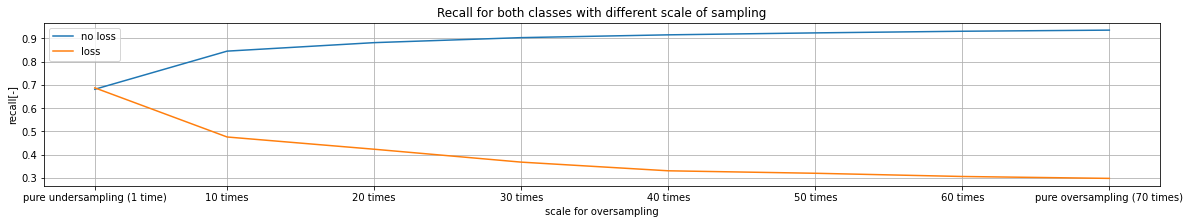

In [42]:
x_ticks = [f'{x} times' for x in num_quantity_time]
x_ticks[0] = 'pure undersampling (1 time)'
x_ticks[-1] = 'pure oversampling (70 times)'
plt.figure(figsize=(20,3))
plt.plot(num_quantity_time, recall_0_list, label='no loss')
plt.plot(num_quantity_time, recall_1_list, label='loss')
plt.xticks(num_quantity_time, x_ticks)
plt.legend()
plt.xlabel('scale for oversampling')
plt.ylabel('recall[-]')
plt.grid()
plt.title('Recall for both classes with different scale of sampling')
plt.show()

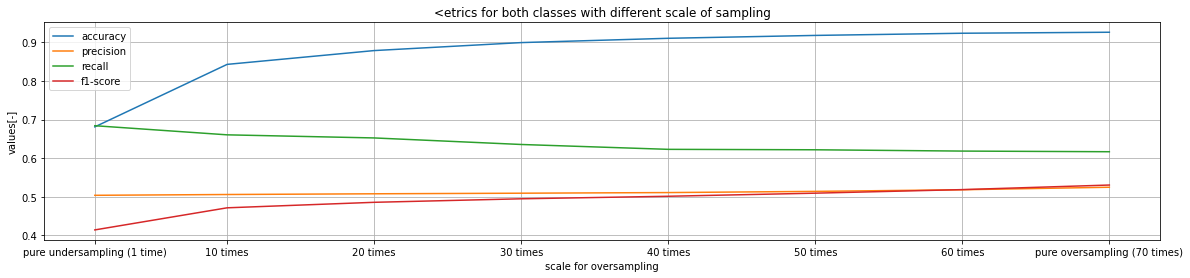

In [43]:
plt.figure(figsize=(20,4))
plt.plot(num_quantity_time, acc, label='accuracy')
plt.plot(num_quantity_time, precision, label='precision')
plt.plot(num_quantity_time, recall, label='recall')
plt.plot(num_quantity_time, f1, label='f1-score')
plt.xticks(num_quantity_time, x_ticks)
plt.legend()
plt.xlabel('scale for oversampling')
plt.ylabel('values[-]')
plt.grid()
plt.title('<etrics for both classes with different scale of sampling')
plt.show()

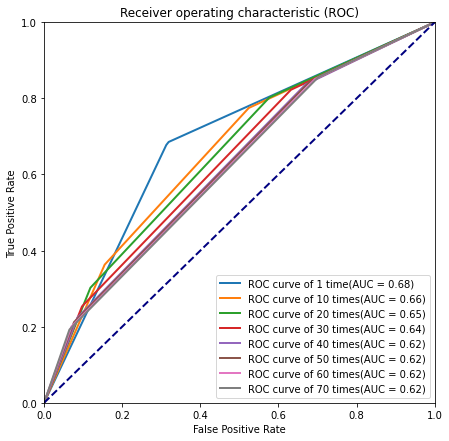

In [52]:
plt.figure(figsize=(7,7))
lw = 2
for i in range(len(fpr_list)):
    if i == 0:
        label = f"ROC curve of {num_quantity_time[i]} time(AUC = %0.2f)" % roc_auc_list[i]
    else:
        label = f"ROC curve of {num_quantity_time[i]} times(AUC = %0.2f)" % roc_auc_list[i]
    plt.plot(fpr_list[i], tpr_list[i], lw=lw, label=label,)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

## Try with RNN

In [215]:
x_train_expand_ = np.expand_dims(x_train_smote, axis = -1)
x_val_expand_ = np.expand_dims(x_validation, axis = -1)

In [216]:
x_train_h_dim = []
for i in range(0, x_train_expand_.shape[0]):
    datum = np.reshape(x_train_expand_[i], (7, 11))
    x_train_h_dim.append(datum)
x_train_h_dim = np.array(x_train_h_dim)

x_val_h_dim = []
for i in range(0, x_val_expand_.shape[0]):
    datum = np.reshape(x_val_expand_[i], (7, 11))
    x_val_h_dim.append(datum)
x_val_h_dim = np.array(x_val_h_dim)

In [218]:
x_train_h_dim.shape

(406180, 7, 11)

In [219]:
x_val_h_dim.shape

(5639, 7, 11)

In [84]:
# x_train_expand = np.expand_dims(x_train_smote, axis = 1)
# x_val_expand= np.expand_dims(x_validation, axis = 1)

In [214]:
callback = keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)

In [220]:
my_rnn_model = keras.Sequential()
my_rnn_model.add(keras.layers.SimpleRNN(64, input_shape=(7, 11), return_sequences=True)) # or with the dataset in the previous comment and change the shape to (1,77)
my_rnn_model.add(keras.layers.SimpleRNN(64, return_sequences=False))
my_rnn_model.add(keras.layers.Dense(2, activation='softmax'))
# my_rnn_model.add(keras.layers.Dense(1, activation='sigmoid'))

my_rnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
#     loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
my_rnn_model.fit(
    x=x_train_h_dim, 
    y=y_train_smote, 
    epochs=10, 
    batch_size=32,
    callbacks=[callback],
    validation_data=(x_val_h_dim, y_validation)
)

## Try with LSTM

In [222]:
my_LSTM_model = keras.Sequential()
my_LSTM_model.add(keras.layers.LSTM(64, input_shape=(7, 11), activation='relu', return_sequences=True))
my_LSTM_model.add(keras.layers.LSTM(64, activation='relu', return_sequences=False))
my_LSTM_model.add(keras.layers.Dense(2, activation='softmax'))

my_LSTM_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
my_LSTM_model.fit(
    x=x_train_h_dim, 
    y=y_train_smote, 
    epochs=10, 
    batch_size=32,
    callbacks=[callback],
    validation_data=(x_val_h_dim, y_validation)
)

In [224]:
x_test_expand_ = np.expand_dims(x_test, axis = -1)
x_test_h_dim = []
for i in range(0, x_test_expand_.shape[0]):
    datum = np.reshape(x_test_expand_[i], (7, 11))
    x_test_h_dim.append(datum)
x_test_h_dim = np.array(x_test_h_dim)

In [225]:
x_test_h_dim.shape

(1803001, 7, 11)

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.83      0.91   1794540
           1       0.02      0.68      0.04      8461

    accuracy                           0.83   1803001
   macro avg       0.51      0.76      0.47   1803001
weighted avg       0.99      0.83      0.90   1803001



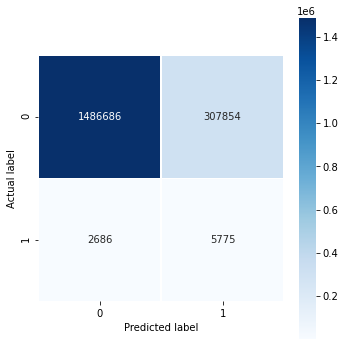

In [101]:
predictions = my_LSTM_model.predict(x_test_h_dim)
prediction_label = [np.argmax(x) for x in predictions]
print("Prediction Report\n", classification_report(y_test, prediction_label))
cm = confusion_matrix(y_test, prediction_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## treat single feature independently (useless!!!)

In [154]:
# x_train_expand_ = np.expand_dims(x_train_smote, axis = 1)
# x_val_expand_ = np.expand_dims(x_validation, axis = 1)

In [155]:
# x_train_expand_.shape

(406180, 1, 77)

In [172]:
# first_input_layer = keras.layers.Input(shape=(1, 77))

# rnn_list = []
# for i in range(0,11):
#     singel_input = keras.layers.Lambda(lambda x: x[:, :, i*7: i*7+7])(first_input_layer)
#     single_rnn_1 = keras.layers.SimpleRNN(10, input_shape=(1, 7), return_sequences=False)(singel_input)
# #     single_rnn_2 = keras.layers.SimpleRNN(32, return_sequences=False)(single_rnn_1)
#     rnn_list.append(single_rnn_1)
    
# combination_layer = keras.layers.concatenate(rnn_list)
# dense_layer_1 = keras.layers.Dense(11, activation='relu')(combination_layer)
# dense_layer_2 = keras.layers.Dense(11, activation='relu')(dense_layer_1)

# output_layer = keras.layers.Dense(2, activation='softmax')(dense_layer_2)

# my_model = keras.models.Model(first_input_layer, output_layer)

# my_model.compile(
#     optimizer=tf.keras.optimizers.Adam(0.001),
#     loss=keras.losses.SparseCategoricalCrossentropy(),
#     metrics=['accuracy']
# )

In [170]:
# my_model.summary()

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_85 (InputLayer)           [(None, 1, 77)]      0                                            
__________________________________________________________________________________________________
lambda_535 (Lambda)             (None, 1, 7)         0           input_85[0][0]                   
__________________________________________________________________________________________________
lambda_536 (Lambda)             (None, 1, 7)         0           input_85[0][0]                   
__________________________________________________________________________________________________
lambda_537 (Lambda)             (None, 1, 7)         0           input_85[0][0]                   
___________________________________________________________________________________________

In [ ]:
# my_model.fit(
#     x=x_train_expand_, 
#     y=y_train_smote, 
#     epochs=10, 
#     batch_size=64,
#     validation_data=(x_val_expand_, y_validation)
# )

#### different time window for lstm

Epoch 1/5
12341/12341 [==============================] - 142s 12ms/step - loss: 0.6221 - accuracy: 0.6505
Epoch 2/5
12341/12341 [==============================] - 141s 11ms/step - loss: 0.5879 - accuracy: 0.6838
Epoch 3/5
12341/12341 [==============================] - 140s 11ms/step - loss: 0.5691 - accuracy: 0.7042
Epoch 4/5
12341/12341 [==============================] - 142s 11ms/step - loss: 0.5554 - accuracy: 0.7180
Epoch 5/5
12341/12341 [==============================] - 143s 12ms/step - loss: 0.5463 - accuracy: 0.7259
Prediction Report with features of past 1000ms
               precision    recall  f1-score   support

           0       1.00      0.76      0.87   1803003
           1       0.01      0.66      0.03      8461

    accuracy                           0.76   1811464
   macro avg       0.51      0.71      0.45   1811464
weighted avg       0.99      0.76      0.86   1811464



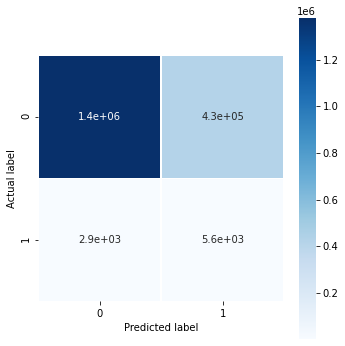

Epoch 1/5
12341/12341 [==============================] - 206s 17ms/step - loss: 0.6022 - accuracy: 0.6711
Epoch 2/5
12341/12341 [==============================] - 201s 16ms/step - loss: 0.5521 - accuracy: 0.7172
Epoch 3/5
12341/12341 [==============================] - 204s 17ms/step - loss: 0.5330 - accuracy: 0.7314
Epoch 4/5
12341/12341 [==============================] - 201s 16ms/step - loss: 0.5193 - accuracy: 0.7416
Epoch 5/5
12341/12341 [==============================] - 202s 16ms/step - loss: 0.5081 - accuracy: 0.7502
Prediction Report with features of past 1500ms
               precision    recall  f1-score   support

           0       1.00      0.79      0.88   1803003
           1       0.01      0.65      0.03      8461

    accuracy                           0.79   1811464
   macro avg       0.51      0.72      0.46   1811464
weighted avg       0.99      0.79      0.88   1811464



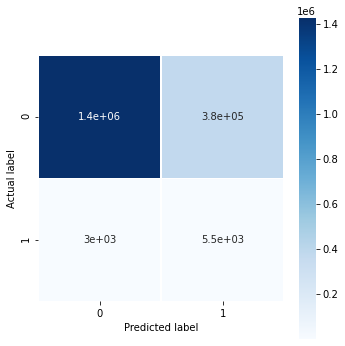

Epoch 1/5
12341/12341 [==============================] - 290s 24ms/step - loss: 0.5919 - accuracy: 0.6774
Epoch 2/5
12341/12341 [==============================] - 327s 27ms/step - loss: 0.5401 - accuracy: 0.7252
Epoch 3/5
12341/12341 [==============================] - 281s 23ms/step - loss: 0.5117 - accuracy: 0.7480
Epoch 4/5
12341/12341 [==============================] - 266s 22ms/step - loss: 0.4932 - accuracy: 0.7611
Epoch 5/5
12341/12341 [==============================] - 316s 26ms/step - loss: 0.4787 - accuracy: 0.7710
Prediction Report with features of past 2000ms
               precision    recall  f1-score   support

           0       1.00      0.71      0.83   1803003
           1       0.01      0.75      0.02      8461

    accuracy                           0.71   1811464
   macro avg       0.51      0.73      0.43   1811464
weighted avg       0.99      0.71      0.83   1811464



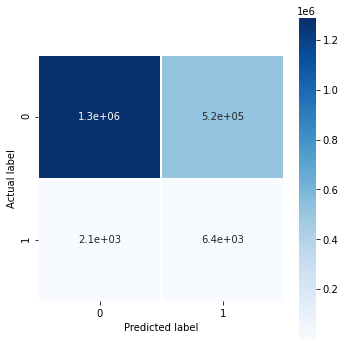

Epoch 1/5
12341/12341 [==============================] - 389s 32ms/step - loss: 0.5797 - accuracy: 0.6890
Epoch 2/5
12341/12341 [==============================] - 415s 34ms/step - loss: 0.5110 - accuracy: 0.7455
Epoch 3/5
12341/12341 [==============================] - 416s 34ms/step - loss: 0.4804 - accuracy: 0.7671
Epoch 4/5
12341/12341 [==============================] - 382s 31ms/step - loss: 0.4618 - accuracy: 0.7803
Epoch 5/5
12341/12341 [==============================] - 393s 32ms/step - loss: 0.4486 - accuracy: 0.7890
Prediction Report with features of past 2500ms
               precision    recall  f1-score   support

           0       1.00      0.80      0.89   1803003
           1       0.02      0.68      0.03      8461

    accuracy                           0.80   1811464
   macro avg       0.51      0.74      0.46   1811464
weighted avg       0.99      0.80      0.88   1811464



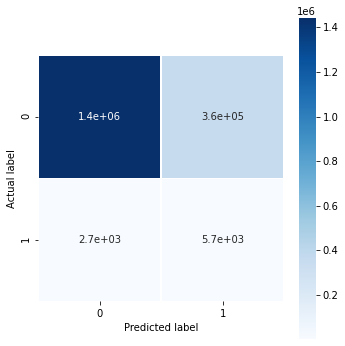

Epoch 1/5
12341/12341 [==============================] - 517s 42ms/step - loss: 0.5696 - accuracy: 0.6954
Epoch 2/5
12341/12341 [==============================] - 771s 62ms/step - loss: 0.4971 - accuracy: 0.7545
Epoch 3/5
12341/12341 [==============================] - 468s 38ms/step - loss: 0.4653 - accuracy: 0.7767
Epoch 4/5
12341/12341 [==============================] - 461s 37ms/step - loss: 0.4439 - accuracy: 0.7908
Epoch 5/5
12341/12341 [==============================] - 460s 37ms/step - loss: 0.4285 - accuracy: 0.8003
Prediction Report with features of past 3000ms
               precision    recall  f1-score   support

           0       1.00      0.83      0.91   1803003
           1       0.02      0.66      0.03      8461

    accuracy                           0.83   1811464
   macro avg       0.51      0.74      0.47   1811464
weighted avg       0.99      0.83      0.90   1811464



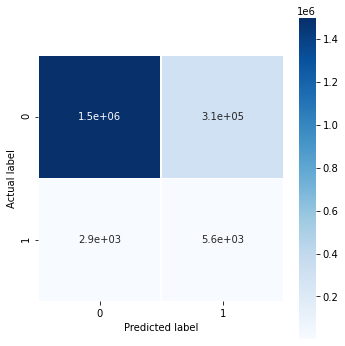

Epoch 1/5
12341/12341 [==============================] - 522s 42ms/step - loss: 0.5686 - accuracy: 0.6967
Epoch 2/5
12341/12341 [==============================] - 528s 43ms/step - loss: 0.4902 - accuracy: 0.7582
Epoch 3/5
12341/12341 [==============================] - 538s 44ms/step - loss: 0.4535 - accuracy: 0.7845
Epoch 4/5
12341/12341 [==============================] - 535s 43ms/step - loss: 0.4290 - accuracy: 0.7998
Epoch 5/5
12341/12341 [==============================] - 620s 50ms/step - loss: 0.4112 - accuracy: 0.8107
Prediction Report with features of past 3500ms
               precision    recall  f1-score   support

           0       1.00      0.80      0.89   1803003
           1       0.02      0.69      0.03      8461

    accuracy                           0.80   1811464
   macro avg       0.51      0.74      0.46   1811464
weighted avg       0.99      0.80      0.88   1811464



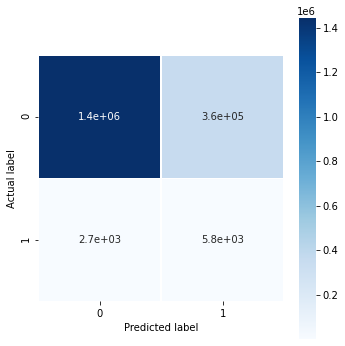

Epoch 1/5
12341/12341 [==============================] - 634s 51ms/step - loss: 0.5582 - accuracy: 0.7066
Epoch 2/5
12341/12341 [==============================] - 633s 51ms/step - loss: 0.4706 - accuracy: 0.7729
Epoch 3/5
12341/12341 [==============================] - 674s 55ms/step - loss: 0.4315 - accuracy: 0.7975
Epoch 4/5
12341/12341 [==============================] - 676s 55ms/step - loss: 0.4076 - accuracy: 0.8122
Epoch 5/5
12341/12341 [==============================] - 695s 56ms/step - loss: 0.3899 - accuracy: 0.8223
Prediction Report with features of past 4000ms
               precision    recall  f1-score   support

           0       1.00      0.83      0.90   1803003
           1       0.02      0.67      0.03      8461

    accuracy                           0.83   1811464
   macro avg       0.51      0.75      0.47   1811464
weighted avg       0.99      0.83      0.90   1811464



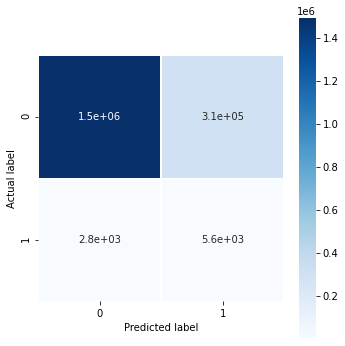

Epoch 1/5
12341/12341 [==============================] - 674s 55ms/step - loss: 0.5489 - accuracy: 0.7137
Epoch 2/5
12341/12341 [==============================] - 659s 53ms/step - loss: 0.4603 - accuracy: 0.7805
Epoch 3/5
12341/12341 [==============================] - 688s 56ms/step - loss: 0.4225 - accuracy: 0.8038
Epoch 4/5
12341/12341 [==============================] - 662s 54ms/step - loss: 0.3976 - accuracy: 0.8188
Epoch 5/5
12341/12341 [==============================] - 664s 54ms/step - loss: 0.3799 - accuracy: 0.8281
Prediction Report with features of past 4500ms
               precision    recall  f1-score   support

           0       1.00      0.79      0.88   1803003
           1       0.02      0.70      0.03      8461

    accuracy                           0.79   1811464
   macro avg       0.51      0.74      0.46   1811464
weighted avg       0.99      0.79      0.88   1811464



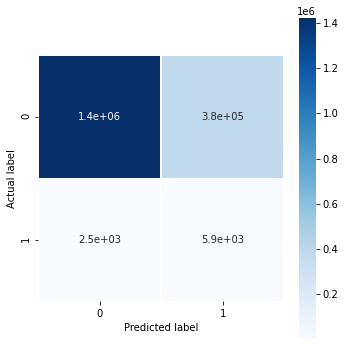

Epoch 1/5
12341/12341 [==============================] - 793s 64ms/step - loss: 0.5394 - accuracy: 0.7186
Epoch 2/5
12341/12341 [==============================] - 797s 65ms/step - loss: 0.4556 - accuracy: 0.7820
Epoch 3/5
12341/12341 [==============================] - 765s 62ms/step - loss: 0.4168 - accuracy: 0.8072
Epoch 4/5
12341/12341 [==============================] - 642s 52ms/step - loss: 0.3903 - accuracy: 0.8221
Epoch 5/5
12341/12341 [==============================] - 715s 58ms/step - loss: 0.3702 - accuracy: 0.8327
Prediction Report with features of past 5000ms
               precision    recall  f1-score   support

           0       1.00      0.79      0.88   1803003
           1       0.02      0.71      0.03      8461

    accuracy                           0.79   1811464
   macro avg       0.51      0.75      0.46   1811464
weighted avg       0.99      0.79      0.88   1811464



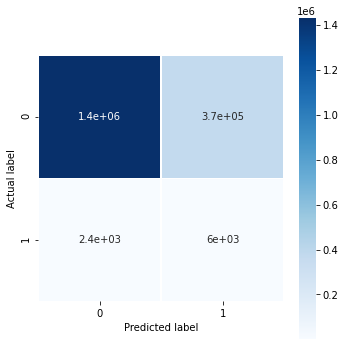

In [28]:
# select value starting from past 5 sec (10 samples) to 0.5 sec (1 sample)

acc = []
precision = []                                         
recall = []
f1 = []
training_acc = []
label = [f'-{500*x}ms' for x in range(10, 1, -1)]

for num_feature in range(3,12):
    
    # build features
    shrink_feature_list = []
    for feature in selected_features_list_removing_correlation:
        for i in range(1, num_feature):
            col_title = f'{feature}_minus_{500*i}ms'
            shrink_feature_list.append(col_title)
            
    # build training and testing dataset
    x_train_new = df_train_shuffled[shrink_feature_list]
    x_test_new = df_test_shuffled[shrink_feature_list]
    y_train_new = df_train_shuffled[['lossOrNot']]
    y_train_new = y_train_new.astype(int)
    y_test_new = df_test_shuffled[['lossOrNot']]
    y_test_new = y_test_new.astype(int)
    
    # oversampling with SMOTE
    smote = SMOTE()
    x_train_smote_new, y_train_smote_new = smote.fit_resample(x_train_new, y_train_new)
    x_train_expand_smote_new = np.expand_dims(x_train_smote_new, axis = -1)
    x_train_h_dim_smote_new = []
    for i in range(0, x_train_expand_smote_new.shape[0]):
        datum = np.reshape(x_train_expand_smote_new[i], (num_feature-1, 11))
        x_train_h_dim_smote_new.append(datum)
    x_train_h_dim_smote_new = np.array(x_train_h_dim_smote_new)
    
    my_LSTM_model_window_size = keras.Sequential()
    my_LSTM_model_window_size.add(keras.layers.LSTM((num_feature-1)*9, input_shape=(num_feature-1, 11), activation='relu', return_sequences=False))
    my_LSTM_model_window_size.add(keras.layers.Dense(1, activation='sigmoid'))

    my_LSTM_model_window_size.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # fit model
    history = my_LSTM_model_window_size.fit(x_train_h_dim_smote_new, y_train_smote_new, epochs=5)
    training_acc.append(history.history['accuracy'][-1])
    
    # output result
    x_test_expand_smote_new = np.expand_dims(x_test_new, axis = -1)
    x_test_h_dim_smote_new = []
    for i in range(0, x_test_expand_smote_new.shape[0]):
        datum = np.reshape(x_test_expand_smote_new[i], (num_feature-1, 11))
        x_test_h_dim_smote_new.append(datum)
    x_test_h_dim_smote_new = np.array(x_test_h_dim_smote_new)
    predictions = my_LSTM_model_window_size.predict(x_test_h_dim_smote_new)
    prediction_label = [0 if x<0.5 else 1 for x in predictions]
    print(f"Prediction Report with features of past {(num_feature-1)*500}ms\n", classification_report(y_test_new, prediction_label))
    cm = confusion_matrix(y_test_new['lossOrNot'].tolist(), prediction_label)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    # store the result, note that the order of values here is opposite with the label, need to reverse later
    report = classification_report(y_test_new, prediction_label, output_dict=True)
    acc.append(report['accuracy'])
    precision.append(report['macro avg']['precision'])                                  
    recall.append(report['macro avg']['recall'])
    f1.append(report['macro avg']['f1-score'])

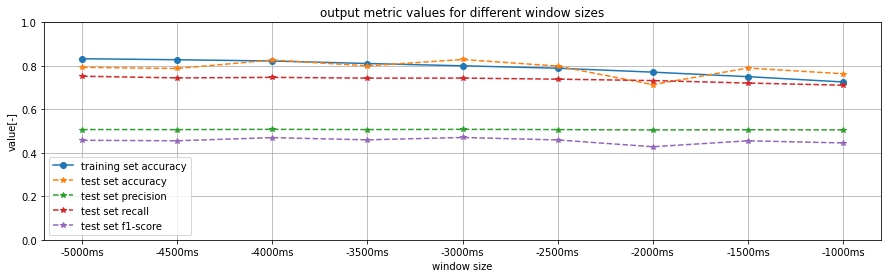

In [51]:
plt.figure(figsize=(15,4))
plt.ylim(0,1)
plt.plot(label, training_acc[::-1], 'o-', label='training set accuracy')
plt.plot(label, acc[::-1], '*--', label='test set accuracy')
plt.plot(label, precision[::-1], '*--', label='test set precision')
plt.plot(label, recall[::-1], '*--', label='test set recall')
plt.plot(label, f1[::-1], '*--', label='test set f1-score')
plt.legend()
plt.xlabel('window size')
plt.ylabel('value[-]')
plt.title('output metric values for different window sizes')
plt.grid()
plt.show()

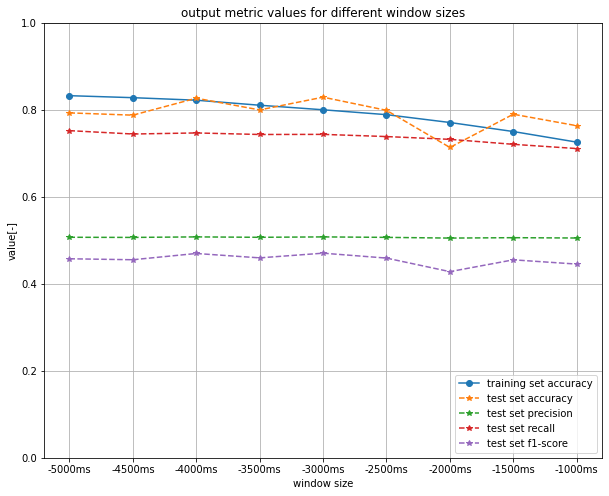

In [52]:
# better plot
plt.figure(figsize=(10,8))
plt.ylim(0,1)
plt.plot(label, training_acc[::-1], 'o-', label='training set accuracy')
plt.plot(label, acc[::-1], '*--', label='test set accuracy')
plt.plot(label, precision[::-1], '*--', label='test set precision')
plt.plot(label, recall[::-1], '*--', label='test set recall')
plt.plot(label, f1[::-1], '*--', label='test set f1-score')
plt.legend(loc=4)
plt.xlabel('window size')
plt.ylabel('value[-]')
plt.title('output metric values for different window sizes')
plt.grid()
plt.show()

## Final LSTM model

In [7]:
# expand the original dataset to higher dimension, from _,77 to _,7,11 (number of samples, number of timestamps, number of features)

x_train_expand = np.expand_dims(x_train_smote, axis = -1)
x_val_expand = np.expand_dims(x_validation, axis = -1)
x_test_expand = np.expand_dims(x_test, axis = -1)

In [8]:
x_train_expand.shape

(406180, 77, 1)

In [9]:
x_train_h_dim = []
for i in range(0, x_train_expand.shape[0]):
    datum = np.reshape(x_train_expand[i], (7, 11))
    x_train_h_dim.append(datum)
x_train_h_dim = np.array(x_train_h_dim)

x_val_h_dim = []
for i in range(0, x_val_expand.shape[0]):
    datum = np.reshape(x_val_expand[i], (7, 11))
    x_val_h_dim.append(datum)
x_val_h_dim = np.array(x_val_h_dim)

x_test_h_dim = []
for i in range(0, x_test_expand.shape[0]):
    datum = np.reshape(x_test_expand[i], (7, 11))
    x_test_h_dim.append(datum)
x_test_h_dim = np.array(x_test_h_dim)

In [10]:
x_train_h_dim.shape

(406180, 7, 11)

In [11]:
# define a call back for early stopping in case the loss stop decreasing in 3 epochs
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3) 

In [15]:
# first try to see the result and then tunning

my_LSTM_model = keras.Sequential()
my_LSTM_model.add(keras.layers.LSTM(64, input_shape=(7, 11), activation='relu', return_sequences=True))
my_LSTM_model.add(keras.layers.LSTM(64, activation='relu', return_sequences=False))
my_LSTM_model.add(keras.layers.Dense(1, activation='sigmoid'))

my_LSTM_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
#     loss=keras.losses.SparseCategoricalCrossentropy(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
my_LSTM_model.fit(
    x=x_train_h_dim, 
    y=y_train_smote, 
    epochs=10, 
    batch_size=64,
    callbacks=[callback],
    validation_data=(x_val_h_dim, y_validation)
)

Epoch 1/10
6347/6347 [==============================] - 469s 74ms/step - loss: 0.5633 - accuracy: 0.6999 - val_loss: 0.5913 - val_accuracy: 0.7044
Epoch 2/10
6347/6347 [==============================] - 466s 73ms/step - loss: 0.4868 - accuracy: 0.7600 - val_loss: 0.5670 - val_accuracy: 0.7250
Epoch 3/10
6347/6347 [==============================] - 468s 74ms/step - loss: 0.4517 - accuracy: 0.7848 - val_loss: 0.5611 - val_accuracy: 0.7328
Epoch 4/10
6347/6347 [==============================] - 503s 79ms/step - loss: 0.4252 - accuracy: 0.8009 - val_loss: 0.6302 - val_accuracy: 0.7138
Epoch 5/10
6347/6347 [==============================] - 641s 101ms/step - loss: 0.4033 - accuracy: 0.8140 - val_loss: 0.5622 - val_accuracy: 0.7347
Epoch 6/10
6347/6347 [==============================] - 748s 118ms/step - loss: 0.3842 - accuracy: 0.8243 - val_loss: 0.5586 - val_accuracy: 0.7446
Epoch 7/10
6347/6347 [==============================] - 802s 126ms/step - loss: 0.3683 - accuracy: 0.8336 - val_loss

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.85      0.92   1794540
           1       0.02      0.64      0.04      8461

    accuracy                           0.85   1803001
   macro avg       0.51      0.74      0.48   1803001
weighted avg       0.99      0.85      0.92   1803001



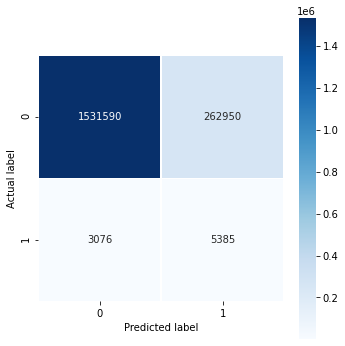

In [17]:
# it's very slow!!!!!!

predictions = my_LSTM_model.predict(x_test_h_dim)
prediction_label = [0 if x<0.5 else 1 for x in predictions]
print("Prediction Report\n", classification_report(y_test, prediction_label))
cm = confusion_matrix(y_test, prediction_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [18]:
# my_LSTM_model.save('models/my_third_nn_model_lstm_fisrt_try')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/my_third_nn_model_lstm_fisrt_try/assets


## Final LSTM model tunning

In [19]:
# model tuning

def build_lstm_model(hp):
    
    model = keras.Sequential()
    
    # fisrt lstm layer with input
    model.add(
        keras.layers.LSTM(
            units=hp.Int("units_1st_lstm_with_input", min_value=16, max_value=64, step=16),
            input_shape=(7, 11), 
            activation=hp.Choice("activation_1st_lstm_with_input", ["relu", "tanh"]),
            return_sequences=True
        )
    )
    
    # possible 2nd lstm layer
    for i in range(hp.Int("num_2nd_lstm_layers", 0, 1)):
        model.add(
            keras.layers.LSTM(
                units=hp.Int(f"units_2nd_lstm_{i}", min_value=16, max_value=64, step=16),
                activation=hp.Choice(f"activation_2nd_lstm_{i}", ["relu", "tanh"]),
#                 return_sequences=hp.Choice(f"return_sequences_{i}", [True, False]),
                return_sequences=True
            )
        )
        if hp.Boolean("dropout"):
            model.add(keras.layers.Dropout(rate=0.2))
            
    # possible 3rd lstm layer
    for i in range(hp.Int("num_3rd_lstm_layers", 0, 1)):
        model.add(
            keras.layers.LSTM(
                units=hp.Int(f"units_3rd_lstm_{i}", min_value=16, max_value=64, step=16),
                activation=hp.Choice(f"activation_3rd_lstm_{i}", ["relu", "tanh"]),
                return_sequences=False
            )
        )
        if hp.Boolean("dropout"):
            model.add(keras.layers.Dropout(rate=0.2))
                
    # possible dense layer
    for i in range(hp.Int("num_dense_layers", 0, 2)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f"units_dense_{i}", min_value=8, max_value=64, step=8),
                activation=hp.Choice(f"activation_dense_{i}", ["relu", "tanh"]),
            )
        )
        if hp.Boolean("dropout"):
            model.add(keras.layers.Dropout(rate=0.2))
                
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=["accuracy"]
    )
    
    return model

build_lstm_model(kt.HyperParameters())

In [20]:
lstm_tuner = kt.RandomSearch(
    hypermodel=build_lstm_model,
    objective="accuracy",
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory="my_lstm_dir",
    project_name="tuning_lstm_nn",
)

In [21]:
lstm_tuner.search_space_summary()

Search space summary
Default search space size: 6
units_1st_lstm_with_input (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
activation_1st_lstm_with_input (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_2nd_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 1, 'step': 1, 'sampling': None}
num_3rd_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 1, 'step': 1, 'sampling': None}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [22]:
lstm_tuner.search(x_train_h_dim, y_train_smote, epochs=1, validation_data=(x_val_h_dim, y_validation))

Trial 50 Complete [00h 04m 24s]
accuracy: 0.6981022357940674

Best accuracy So Far: 0.7371140718460083
Total elapsed time: 06h 46m 29s
INFO:tensorflow:Oracle triggered exit


In [23]:
lstm_tuner.results_summary()

Results summary
Results in my_lstm_dir/tuning_lstm_nn
Showing 10 best trials
Trial summary
Hyperparameters:
units_1st_lstm_with_input: 48
activation_1st_lstm_with_input: tanh
num_2nd_lstm_layers: 0
num_3rd_lstm_layers: 1
num_dense_layers: 1
lr: 0.007457260244324495
units_dense_0: 24
activation_dense_0: relu
dropout: False
units_2nd_lstm_0: 32
activation_2nd_lstm_0: relu
units_3rd_lstm_0: 48
activation_3rd_lstm_0: tanh
units_dense_1: 56
activation_dense_1: tanh
Score: 0.7371140718460083
Trial summary
Hyperparameters:
units_1st_lstm_with_input: 48
activation_1st_lstm_with_input: tanh
num_2nd_lstm_layers: 0
num_3rd_lstm_layers: 1
num_dense_layers: 2
lr: 0.0064737119407353
units_dense_0: 16
activation_dense_0: tanh
dropout: True
units_2nd_lstm_0: 16
activation_2nd_lstm_0: tanh
units_3rd_lstm_0: 64
activation_3rd_lstm_0: tanh
units_dense_1: 24
activation_dense_1: tanh
Score: 0.7313210964202881
Trial summary
Hyperparameters:
units_1st_lstm_with_input: 64
activation_1st_lstm_with_input: tanh


In [32]:
best_lstm_hps = lstm_tuner.get_best_hyperparameters(5)
my_final_lstm_model = build_lstm_model(best_lstm_hps[0])

# put train and validation together
x_train_all = np.concatenate((x_train_h_dim, x_val_h_dim))
y_train_all = pd.concat([y_train_smote, y_validation])

In [33]:
x_train_all.shape

(411819, 7, 11)

In [34]:
# Hyperparameters:
# units_1st_lstm_with_input: 48
# activation_1st_lstm_with_input: tanh
# num_2nd_lstm_layers: 0
# num_3rd_lstm_layers: 1
# num_dense_layers: 1
# lr: 0.007457260244324495
# units_dense_0: 24
# activation_dense_0: relu
# dropout: False
# units_2nd_lstm_0: 32
# activation_2nd_lstm_0: relu
# units_3rd_lstm_0: 48
# activation_3rd_lstm_0: tanh
# units_dense_1: 56
# activation_dense_1: tanh
# Score: 0.7371140718460083

my_final_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 7, 48)             11520     
_________________________________________________________________
lstm_6 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dense_6 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 31,345
Trainable params: 31,345
Non-trainable params: 0
_________________________________________________________________


In [35]:
my_final_lstm_model.fit(x=x_train_all, y=y_train_all, epochs=20, batch_size=64, callbacks=[callback])

Epoch 1/20
6435/6435 [==============================] - 259s 40ms/step - loss: 0.5293 - accuracy: 0.7236
Epoch 2/20
6435/6435 [==============================] - 265s 41ms/step - loss: 0.4253 - accuracy: 0.8010
Epoch 3/20
6435/6435 [==============================] - 281s 44ms/step - loss: 0.3901 - accuracy: 0.8205
Epoch 4/20
6435/6435 [==============================] - 264s 41ms/step - loss: 0.3700 - accuracy: 0.8321
Epoch 5/20
6435/6435 [==============================] - 265s 41ms/step - loss: 0.3551 - accuracy: 0.8404
Epoch 6/20
6435/6435 [==============================] - 292s 45ms/step - loss: 0.3433 - accuracy: 0.8481
Epoch 7/20
6435/6435 [==============================] - 316s 49ms/step - loss: 0.3333 - accuracy: 0.8542
Epoch 8/20
6435/6435 [==============================] - 268s 42ms/step - loss: 0.3255 - accuracy: 0.8581
Epoch 9/20
6435/6435 [==============================] - 262s 41ms/step - loss: 0.3191 - accuracy: 0.8612
Epoch 10/20
6435/6435 [==============================] 

In [36]:
my_final_lstm_model.save('models/my_fifth_nn_model_lstm')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/my_fifth_nn_model_lstm/assets


Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.86      0.92   1794540
           1       0.02      0.62      0.04      8461

    accuracy                           0.86   1803001
   macro avg       0.51      0.74      0.48   1803001
weighted avg       0.99      0.86      0.92   1803001



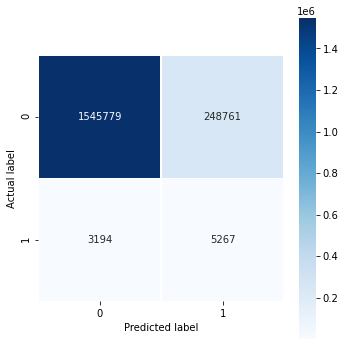

In [38]:
predictions = my_final_lstm_model.predict(x_test_h_dim)
prediction_label = [0 if x<0.5 else 1 for x in predictions]
print("Prediction Report\n", classification_report(y_test, prediction_label))
cm = confusion_matrix(y_test['lossOrNot'].tolist(), prediction_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## Final RNN model

In [34]:
# first try to see the result and then tunning

my_rnn_model = keras.Sequential()
my_rnn_model.add(keras.layers.SimpleRNN(64, input_shape=(7, 11), activation='relu', return_sequences=True))
my_rnn_model.add(keras.layers.SimpleRNN(64, activation='relu', return_sequences=False))
my_rnn_model.add(keras.layers.Dense(1, activation='sigmoid'))

my_rnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [35]:
my_rnn_model.fit(
    x=x_train_h_dim, 
    y=y_train_smote, 
    epochs=10, 
    batch_size=64,
    callbacks=[callback],
    validation_data=(x_val_h_dim, y_validation)
)

Epoch 1/10
6347/6347 [==============================] - 170s 27ms/step - loss: 0.5109 - accuracy: 0.7426 - val_loss: 0.5485 - val_accuracy: 0.7333
Epoch 2/10
6347/6347 [==============================] - 165s 26ms/step - loss: 0.4365 - accuracy: 0.7959 - val_loss: 0.5702 - val_accuracy: 0.7358
Epoch 3/10
6347/6347 [==============================] - 161s 25ms/step - loss: 0.4078 - accuracy: 0.8122 - val_loss: 0.5742 - val_accuracy: 0.7365
Epoch 4/10
6347/6347 [==============================] - 171s 27ms/step - loss: 0.3881 - accuracy: 0.8236 - val_loss: 0.5773 - val_accuracy: 0.7411
Epoch 5/10
6347/6347 [==============================] - 159s 25ms/step - loss: 0.3742 - accuracy: 0.8307 - val_loss: 0.5853 - val_accuracy: 0.7377
Epoch 6/10
6347/6347 [==============================] - 181s 29ms/step - loss: 0.3636 - accuracy: 0.8363 - val_loss: 0.6009 - val_accuracy: 0.7365
Epoch 7/10
6347/6347 [==============================] - 170s 27ms/step - loss: 0.3549 - accuracy: 0.8406 - val_loss: 0

Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.79      0.88   1794540
           1       0.02      0.69      0.03      8461

    accuracy                           0.79   1803001
   macro avg       0.51      0.74      0.45   1803001
weighted avg       0.99      0.79      0.88   1803001



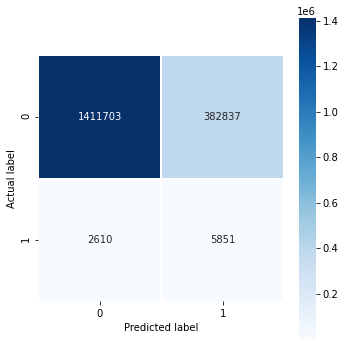

In [36]:
predictions = my_rnn_model.predict(x_test_h_dim)
prediction_label = [0 if x<0.5 else 1 for x in predictions]
print("Prediction Report\n", classification_report(y_test, prediction_label))
cm = confusion_matrix(y_test, prediction_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [37]:
# my_rnn_model.save('models/my_fourth_nn_model_rnn_fisrt_try')

INFO:tensorflow:Assets written to: models/my_fourth_nn_model_rnn_fisrt_try/assets


## Final RNN tunning

In [13]:
# model tuning

def build_rnn_model(hp):
    
    model = keras.Sequential()
    
    # fisrt rnn layer with input
    model.add(
        keras.layers.SimpleRNN(
            units=hp.Int("units_1st_rnn_with_input", min_value=16, max_value=64, step=16),
            input_shape=(7, 11), 
            activation=hp.Choice("activation_1st_rnn_with_input", ["relu", "tanh"]),
            return_sequences=True
        )
    )
    
    # possible 2nd rnn layer
    for i in range(hp.Int("num_2nd_rnn_layers", 0, 1)):
        model.add(
            keras.layers.SimpleRNN(
                units=hp.Int(f"units_2nd_rnn_{i}", min_value=16, max_value=64, step=16),
                activation=hp.Choice(f"activation_2nd_rnn_{i}", ["relu", "tanh"]),
                return_sequences=True
            )
        )
        if hp.Boolean("dropout"):
            model.add(keras.layers.Dropout(rate=0.2))
            
    # possible 3rd rnn layer
    for i in range(hp.Int("num_3rd_rnn_layers", 0, 1)):
        model.add(
            keras.layers.SimpleRNN(
                units=hp.Int(f"units_3rd_rnn_{i}", min_value=16, max_value=64, step=16),
                activation=hp.Choice(f"activation_3rd_rnn_{i}", ["relu", "tanh"]),
                return_sequences=False
            )
        )
        if hp.Boolean("dropout"):
            model.add(keras.layers.Dropout(rate=0.2))
                
    # possible dense layer
    for i in range(hp.Int("num_dense_layers", 0, 2)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f"units_dense_{i}", min_value=8, max_value=64, step=8),
                activation=hp.Choice(f"activation_dense_{i}", ["relu", "tanh"]),
            )
        )
        if hp.Boolean("dropout"):
            model.add(keras.layers.Dropout(rate=0.2))
                
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=["accuracy"]
    )
    
    return model

build_rnn_model(kt.HyperParameters())

In [14]:
rnn_tuner = kt.RandomSearch(
    hypermodel=build_rnn_model,
    objective="accuracy",
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory="my_rnn_dir",
    project_name="tuning_rnn",
)

In [15]:
rnn_tuner.search_space_summary()

Search space summary
Default search space size: 6
units_1st_rnn_with_input (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
activation_1st_rnn_with_input (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_2nd_rnn_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 1, 'step': 1, 'sampling': None}
num_3rd_rnn_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 1, 'step': 1, 'sampling': None}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [17]:
rnn_tuner.search(x_train_h_dim, y_train_smote, epochs=1, validation_data=(x_val_h_dim, y_validation))

Trial 50 Complete [00h 07m 11s]
accuracy: 0.668349027633667

Best accuracy So Far: 0.743549644947052
Total elapsed time: 07h 57m 41s
INFO:tensorflow:Oracle triggered exit


In [18]:
rnn_tuner.results_summary()

Results summary
Results in my_rnn_dir/tuning_rnn
Showing 10 best trials
Trial summary
Hyperparameters:
units_1st_rnn_with_input: 64
activation_1st_rnn_with_input: relu
num_2nd_rnn_layers: 0
num_3rd_rnn_layers: 1
num_dense_layers: 0
lr: 0.001958975633214816
units_2nd_rnn_0: 32
activation_2nd_rnn_0: relu
dropout: True
units_dense_0: 40
activation_dense_0: tanh
units_dense_1: 56
activation_dense_1: tanh
units_3rd_rnn_0: 32
activation_3rd_rnn_0: tanh
Score: 0.743549644947052
Trial summary
Hyperparameters:
units_1st_rnn_with_input: 64
activation_1st_rnn_with_input: relu
num_2nd_rnn_layers: 0
num_3rd_rnn_layers: 1
num_dense_layers: 0
lr: 0.0012106145307524464
units_2nd_rnn_0: 32
activation_2nd_rnn_0: relu
dropout: False
units_dense_0: 32
activation_dense_0: relu
units_dense_1: 24
activation_dense_1: relu
units_3rd_rnn_0: 16
activation_3rd_rnn_0: relu
Score: 0.7393003106117249
Trial summary
Hyperparameters:
units_1st_rnn_with_input: 48
activation_1st_rnn_with_input: relu
num_2nd_rnn_layers: 1

In [19]:
best_rnn_hps = rnn_tuner.get_best_hyperparameters(5)
my_final_rnn_model = build_rnn_model(best_rnn_hps[0])

# put train and validation together
x_train_all = np.concatenate((x_train_h_dim, x_val_h_dim))
y_train_all = pd.concat([y_train_smote, y_validation])

In [20]:
# Trial summary
# Hyperparameters:
# units_1st_rnn_with_input: 64
# activation_1st_rnn_with_input: relu
# num_2nd_rnn_layers: 0
# num_3rd_rnn_layers: 1
# num_dense_layers: 0
# lr: 0.001958975633214816
# units_2nd_rnn_0: 32
# activation_2nd_rnn_0: relu
# dropout: True
# units_dense_0: 40
# activation_dense_0: tanh
# units_dense_1: 56
# activation_dense_1: tanh
# units_3rd_rnn_0: 32
# activation_3rd_rnn_0: tanh
# Score: 0.743549644947052

my_final_rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 7, 64)             4864      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [21]:
my_final_rnn_model.fit(x=x_train_all, y=y_train_all, epochs=20, batch_size=64, callbacks=[callback])

Epoch 1/20
6435/6435 [==============================] - 283s 44ms/step - loss: 0.5178 - accuracy: 0.7411
Epoch 2/20
6435/6435 [==============================] - 280s 43ms/step - loss: 0.4543 - accuracy: 0.7859
Epoch 3/20
6435/6435 [==============================] - 283s 44ms/step - loss: 0.4341 - accuracy: 0.7982
Epoch 4/20
6435/6435 [==============================] - 286s 44ms/step - loss: 0.4204 - accuracy: 0.8065
Epoch 5/20
6435/6435 [==============================] - 282s 44ms/step - loss: 0.4119 - accuracy: 0.8115
Epoch 6/20
6435/6435 [==============================] - 281s 44ms/step - loss: 0.4044 - accuracy: 0.8164
Epoch 7/20
6435/6435 [==============================] - 286s 44ms/step - loss: 0.3991 - accuracy: 0.8196
Epoch 8/20
6435/6435 [==============================] - 277s 43ms/step - loss: 0.3943 - accuracy: 0.8220
Epoch 9/20
6435/6435 [==============================] - 280s 43ms/step - loss: 0.3904 - accuracy: 0.8239
Epoch 10/20
6435/6435 [==============================] 

In [22]:
my_final_rnn_model.save('models/my_sixth_nn_model_rnn')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/my_sixth_nn_model_rnn/assets


Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.80      0.89   1794540
           1       0.02      0.69      0.03      8461

    accuracy                           0.80   1803001
   macro avg       0.51      0.74      0.46   1803001
weighted avg       0.99      0.80      0.88   1803001



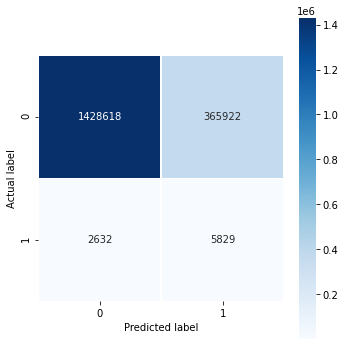

In [23]:
predictions = my_final_rnn_model.predict(x_test_h_dim)
prediction_label = [0 if x<0.5 else 1 for x in predictions]
print("Prediction Report\n", classification_report(y_test, prediction_label))
cm = confusion_matrix(y_test, prediction_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

#### Tuning for LSTM model with 5s 

In [22]:
# define validation dataset
# oversampling to 12 times since 10% of original dataset are used as validation

#training
# 6 times for faster search but 12 times for real training
df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.6)], df_no_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.6 * 6)]]) 
df_train_shuffled = df_train.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)

# validation
df_validation = pd.concat([
    df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0]*0.6)+1 : int(df_loss_shuffled.shape[0]*0.7)], 
    df_no_loss_shuffled.iloc[int(df_loss_shuffled.shape[0]*0.6*12)+1 : int(df_loss_shuffled.shape[0]*(0.6*12+0.1))]
])
df_validation_shuffled = df_validation.sample(frac=1).reset_index()
df_validation_shuffled.drop(['index'], axis=1, inplace=True)

# test
df_test = pd.concat([df_loss_shuffled.iloc[int(df_loss_shuffled.shape[0]*0.7)+1: -1], df_no_loss_shuffled.iloc[int(df_loss_shuffled.shape[0]*(0.6*12+0.1))+1: -1]])
df_test_shuffled = df_test.sample(frac=1).reset_index()
df_test_shuffled.drop(['index'], axis=1, inplace=True)

# build features for past 3500ms (7 samples)
shrink_feature_list = []
for feature in selected_features_list_removing_correlation:
    for i in range(1, 8):
        col_title = f'{feature}_minus_{500*i}ms'
        shrink_feature_list.append(col_title)

x_train = df_train_shuffled[full_features_list]
x_validation = df_validation_shuffled[full_features_list]
x_test = df_test_shuffled[full_features_list]
y_train = df_train_shuffled[['lossOrNot']]
y_train = y_train.astype(int)
y_validation = df_validation_shuffled[['lossOrNot']]
y_validation = y_validation.astype(int)
y_test = df_test_shuffled[['lossOrNot']]
y_test = y_test.astype(int)

smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [23]:
x_train_expand = np.expand_dims(x_train_smote, axis = -1)
x_val_expand = np.expand_dims(x_validation, axis = -1)
x_test_expand = np.expand_dims(x_test, axis = -1)

In [24]:
x_train_h_dim = []
for i in range(0, x_train_expand.shape[0]):
    datum = np.reshape(x_train_expand[i], (10, 11))
    x_train_h_dim.append(datum)
x_train_h_dim = np.array(x_train_h_dim)

x_val_h_dim = []
for i in range(0, x_val_expand.shape[0]):
    datum = np.reshape(x_val_expand[i], (10, 11))
    x_val_h_dim.append(datum)
x_val_h_dim = np.array(x_val_h_dim)

x_test_h_dim = []
for i in range(0, x_test_expand.shape[0]):
    datum = np.reshape(x_test_expand[i], (10, 11))
    x_test_h_dim.append(datum)
x_test_h_dim = np.array(x_test_h_dim)

In [25]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3) 

In [26]:
# model tuning

def build_lstm_model(hp):
    
    model = keras.Sequential()
    
    # fisrt lstm layer with input
    model.add(
        keras.layers.LSTM(
            units=hp.Int("units_1st_lstm_with_input", min_value=16, max_value=64, step=16),
            input_shape=(10, 11), 
            activation=hp.Choice("activation_1st_lstm_with_input", ["relu", "tanh"]),
            return_sequences=True
        )
    )
    
    # possible 2nd lstm layer
    for i in range(hp.Int("num_2nd_lstm_layers", 0, 1)):
        model.add(
            keras.layers.LSTM(
                units=hp.Int(f"units_2nd_lstm_{i}", min_value=16, max_value=64, step=16),
                activation=hp.Choice(f"activation_2nd_lstm_{i}", ["relu", "tanh"]),
#                 return_sequences=hp.Choice(f"return_sequences_{i}", [True, False]),
                return_sequences=True
            )
        )
        if hp.Boolean("dropout"):
            model.add(keras.layers.Dropout(rate=0.2))
            
    # possible 3rd lstm layer
    for i in range(hp.Int("num_3rd_lstm_layers", 0, 1)):
        model.add(
            keras.layers.LSTM(
                units=hp.Int(f"units_3rd_lstm_{i}", min_value=16, max_value=64, step=16),
                activation=hp.Choice(f"activation_3rd_lstm_{i}", ["relu", "tanh"]),
                return_sequences=False
            )
        )
        if hp.Boolean("dropout"):
            model.add(keras.layers.Dropout(rate=0.2))
                
    # possible dense layer
    for i in range(hp.Int("num_dense_layers", 0, 2)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f"units_dense_{i}", min_value=8, max_value=64, step=8),
                activation=hp.Choice(f"activation_dense_{i}", ["relu", "tanh"]),
            )
        )
        if hp.Boolean("dropout"):
            model.add(keras.layers.Dropout(rate=0.2))
                
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=["accuracy"]
    )
    
    return model

build_lstm_model(kt.HyperParameters())

In [27]:
lstm_tuner = kt.RandomSearch(
    hypermodel=build_lstm_model,
    objective="accuracy",
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory="my_lstm_dir",
    project_name="tuning_lstm_nn",
)

In [28]:
lstm_tuner.search_space_summary()

Search space summary
Default search space size: 6
units_1st_lstm_with_input (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
activation_1st_lstm_with_input (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_2nd_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 1, 'step': 1, 'sampling': None}
num_3rd_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 1, 'step': 1, 'sampling': None}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [29]:
lstm_tuner.search(x_train_h_dim, y_train_smote, epochs=2) # validation_data=(x_val_h_dim, y_validation)

Trial 50 Complete [00h 14m 50s]
accuracy: 0.6458519697189331

Best accuracy So Far: 0.7658279538154602
Total elapsed time: 10h 08m 36s
INFO:tensorflow:Oracle triggered exit


In [30]:
lstm_tuner.results_summary()

Results summary
Results in my_lstm_dir/tuning_lstm_nn
Showing 10 best trials
Trial summary
Hyperparameters:
units_1st_lstm_with_input: 48
activation_1st_lstm_with_input: tanh
num_2nd_lstm_layers: 1
num_3rd_lstm_layers: 1
num_dense_layers: 0
lr: 0.002739740054213502
units_2nd_lstm_0: 16
activation_2nd_lstm_0: relu
dropout: False
units_3rd_lstm_0: 16
activation_3rd_lstm_0: relu
Score: 0.7658279538154602
Trial summary
Hyperparameters:
units_1st_lstm_with_input: 64
activation_1st_lstm_with_input: tanh
num_2nd_lstm_layers: 0
num_3rd_lstm_layers: 1
num_dense_layers: 0
lr: 0.0014420623580721453
units_2nd_lstm_0: 32
activation_2nd_lstm_0: tanh
dropout: False
units_3rd_lstm_0: 32
activation_3rd_lstm_0: tanh
units_dense_0: 48
activation_dense_0: tanh
units_dense_1: 56
activation_dense_1: relu
Score: 0.764365553855896
Trial summary
Hyperparameters:
units_1st_lstm_with_input: 48
activation_1st_lstm_with_input: tanh
num_2nd_lstm_layers: 1
num_3rd_lstm_layers: 1
num_dense_layers: 1
lr: 0.00381449785

In [31]:
best_lstm_hps = lstm_tuner.get_best_hyperparameters(5)
my_final_lstm_model = build_lstm_model(best_lstm_hps[0])

In [32]:
my_final_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 48)            11520     
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 16)            4160      
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 17,809
Trainable params: 17,809
Non-trainable params: 0
_________________________________________________________________


In [34]:
df_train = pd.concat([df_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.6)], df_no_loss_shuffled.iloc[0:int(df_loss_shuffled.shape[0] * 0.6 * 12)]]) 
df_train_shuffled = df_train.sample(frac=1).reset_index()
df_train_shuffled.drop(['index'], axis=1, inplace=True)

x_train = df_train_shuffled[full_features_list]
y_train = df_train_shuffled[['lossOrNot']]
y_train = y_train.astype(int)

smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

x_train_expand = np.expand_dims(x_train_smote, axis = -1)

x_train_h_dim = []
for i in range(0, x_train_expand.shape[0]):
    datum = np.reshape(x_train_expand[i], (10, 11))
    x_train_h_dim.append(datum)
x_train_h_dim = np.array(x_train_h_dim)

In [40]:
my_final_lstm_model.fit(
    x=x_train_h_dim, 
    y=y_train_smote, 
    epochs=30, 
    batch_size=64, 
    callbacks=[callback], 
    validation_data=(x_val_h_dim, y_validation)
)

Epoch 1/30
6347/6347 [==============================] - 564s 89ms/step - loss: 0.5205 - accuracy: 0.7370 - val_loss: 0.5268 - val_accuracy: 0.7372
Epoch 2/30
6347/6347 [==============================] - 608s 96ms/step - loss: 0.4322 - accuracy: 0.7964 - val_loss: 0.5207 - val_accuracy: 0.7521
Epoch 3/30
6347/6347 [==============================] - 605s 95ms/step - loss: 0.3999 - accuracy: 0.8145 - val_loss: 0.5549 - val_accuracy: 0.7480
Epoch 4/30
6347/6347 [==============================] - 590s 93ms/step - loss: 0.3781 - accuracy: 0.8259 - val_loss: 0.5556 - val_accuracy: 0.7516
Epoch 5/30
6347/6347 [==============================] - 559s 88ms/step - loss: 0.3606 - accuracy: 0.8357 - val_loss: 0.5624 - val_accuracy: 0.7508


Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.83      0.91   1794540
           1       0.02      0.69      0.04      8461

    accuracy                           0.83   1803001
   macro avg       0.51      0.76      0.47   1803001
weighted avg       0.99      0.83      0.90   1803001



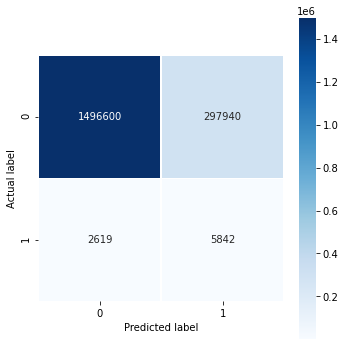

In [41]:
predictions = my_final_lstm_model.predict(x_test_h_dim)
prediction_label = [0 if x<0.5 else 1 for x in predictions]
print("Prediction Report\n", classification_report(y_test, prediction_label))
cm = confusion_matrix(y_test['lossOrNot'].tolist(), prediction_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [42]:
# keep training for training set plus validation set

x_train_all = np.concatenate((x_train_h_dim, x_val_h_dim))
y_train_all = pd.concat([y_train_smote, y_validation])

my_final_lstm_model.fit(
    x=x_train_all, 
    y=y_train_all, 
    epochs=5, 
    batch_size=64
)

Epoch 1/5
6435/6435 [==============================] - 629s 98ms/step - loss: 0.3502 - accuracy: 0.8412
Epoch 2/5
6435/6435 [==============================] - 574s 89ms/step - loss: 0.3399 - accuracy: 0.8476
Epoch 3/5
6435/6435 [==============================] - 577s 90ms/step - loss: 0.3309 - accuracy: 0.8516
Epoch 4/5
6435/6435 [==============================] - 570s 89ms/step - loss: 0.3235 - accuracy: 0.8557
Epoch 5/5
6435/6435 [==============================] - 628s 98ms/step - loss: 0.3175 - accuracy: 0.8589


Prediction Report
               precision    recall  f1-score   support

           0       1.00      0.81      0.89   1794540
           1       0.02      0.71      0.03      8461

    accuracy                           0.81   1803001
   macro avg       0.51      0.76      0.46   1803001
weighted avg       0.99      0.81      0.89   1803001



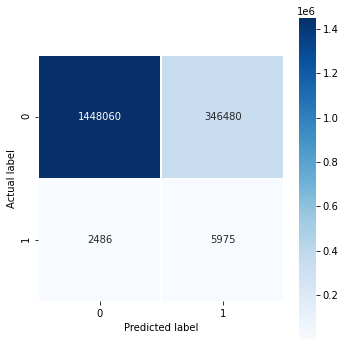

In [43]:
predictions = my_final_lstm_model.predict(x_test_h_dim)
prediction_label = [0 if x<0.5 else 1 for x in predictions]
print("Prediction Report\n", classification_report(y_test, prediction_label))
cm = confusion_matrix(y_test['lossOrNot'].tolist(), prediction_label)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square = True, cmap = 'Blues', fmt='d')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()